In [1]:
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

sys.path.append("../")

from src.readers.geom_reader import load_geodata
from src.timeseries_stats.metrics import evaluate_model
from src.utils.logger import setup_logger

# Plot styling
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300

log = setup_logger("test_periods", log_file="../logs/test_periods.log")

# Define test periods configuration
test_periods = ["forward_1", "forward_2", "forward_3", "back_1", "back_2", "back_3"]
forward_periods = ["forward_1", "forward_2", "forward_3"]
backward_periods = ["back_1", "back_2", "back_3"]
predictions_path = Path("../data/predictions/lstm_different_test_periods")

# Period configuration with train/val/test years (from lstm_different_test_experiment.py)
period_info = {
    "forward_1": {
        "train_years": "2008-2014",
        "train_duration": 7,
        "val_years": "2015-2016",
        "val_duration": 2,
        "test_years": "2017-2018",
        "test_duration": 2,
        "direction": "Forward",
    },
    "forward_2": {
        "train_years": "2008-2012",
        "train_duration": 5,
        "val_years": "2013-2014",
        "val_duration": 2,
        "test_years": "2015-2018",
        "test_duration": 4,
        "direction": "Forward",
    },
    "forward_3": {
        "train_years": "2008-2010",
        "train_duration": 3,
        "val_years": "2011-2012",
        "val_duration": 2,
        "test_years": "2013-2018",
        "test_duration": 6,
        "direction": "Forward",
    },
    "back_1": {
        "train_years": "2012-2018",
        "train_duration": 7,
        "val_years": "2010-2011",
        "val_duration": 2,
        "test_years": "2008-2009",
        "test_duration": 2,
        "direction": "Backward",
    },
    "back_2": {
        "train_years": "2014-2018",
        "train_duration": 5,
        "val_years": "2012-2013",
        "val_duration": 2,
        "test_years": "2008-2011",
        "test_duration": 4,
        "direction": "Backward",
    },
    "back_3": {
        "train_years": "2016-2018",
        "train_duration": 3,
        "val_years": "2014-2015",
        "val_duration": 2,
        "test_years": "2008-2013",
        "test_duration": 6,
        "direction": "Backward",
    },
}

# Create display labels for plots
period_labels = {
    p: f"{p.replace('_', ' ').title()}\n({info['test_years']})"
    for p, info in period_info.items()
}
period_labels_short = {p: f"{info['test_years']}" for p, info in period_info.items()}

# Focus on 3 key metrics
metric_names = ["NSE", "KGE", "r"]

In [2]:
area_weighted = False

In [3]:
# Load watershed geometries and gauge locations
ws, gauges = load_geodata(folder_depth="../")
common_index = gauges.index.to_list()
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")

fine_tune_gauges = gpd.read_file("../data/res/FineTuneGauges.gpkg")[
    [
        "gauge_id",
        "name_ru",
        "name_en",
        "geometry",
    ]
]
fine_tune_gauges.set_index("gauge_id", inplace=True)

ft_index = fine_tune_gauges.index.tolist()

rest_gauges = gauges.loc[~gauges.index.isin(ft_index)]
rest_index = rest_gauges.index.tolist()
print(f"Loaded {len(gauges)} gauges with hybrid classification")


Loaded 996 gauges with hybrid classification


In [4]:
# Load all predictions and compute metrics for all gauges and periods
model_data = {}
all_metrics_records = []

for period_tag in test_periods:
    model_data[period_tag] = {}
    for gauge_id in gauges.index:
        file_path = (
            predictions_path / str(gauge_id) / f"{gauge_id}_{period_tag}_predictions.csv"
        )

        if not file_path.exists():
            log.warning(f"File not found: {file_path}")
            continue

        data_df = pd.read_csv(
            file_path,
            index_col="date",
            parse_dates=True,
        )

        metrics = evaluate_model(
            observed=data_df["q_obs"],
            simulated=data_df["q_sim"],
        )
        model_data[period_tag][gauge_id] = metrics

        # Create record for DataFrame
        record = {"gauge_id": gauge_id, "period": period_tag}
        record.update(metrics)
        all_metrics_records.append(record)

# Create comprehensive metrics DataFrame
metrics_df = pd.DataFrame(all_metrics_records)
metrics_df.set_index("gauge_id", inplace=True)

print(f"Loaded metrics for {len(metrics_df)} gauge-period combinations")
print(f"Number of gauges: {metrics_df.index.nunique()}")
print(f"Number of periods: {metrics_df['period'].nunique()}")

Loaded metrics for 5976 gauge-period combinations
Number of gauges: 996
Number of periods: 6


In [5]:
# Create wide-format DataFrames for each metric (gauge x period)
metrics_wide = {}
for metric in metric_names:
    metrics_wide[metric] = metrics_df.pivot_table(
        values=metric, index=metrics_df.index, columns="period"
    )[test_periods]  # Reorder columns

# Create clipped NSE for visualizations (clip to [-1, 1] to handle extreme values)
metrics_wide["NSE_clipped"] = metrics_wide["NSE"].clip(lower=-1, upper=1)
metrics_wide["KGE_clipped"] = metrics_wide["KGE"].clip(lower=-1, upper=1)

# Report on clipped values
n_clipped = (metrics_wide["NSE"] != metrics_wide["NSE_clipped"]).sum().sum()
n_total = metrics_wide["NSE"].notna().sum().sum()
print(
    f"NSE clipping: {n_clipped} values ({n_clipped / n_total * 100:.1f}%) clipped to [-1, 1]"
)

# Preview NSE wide format
print("\nNSE by period (sample):")
metrics_wide["NSE"].head(10)

NSE clipping: 122 values (2.0%) clipped to [-1, 1]

NSE by period (sample):


period    forward_1  forward_2  forward_3    back_1    back_2    back_3
gauge_id                                                               
10042      0.899805   0.908215   0.811629  0.870450  0.908063  0.911493
10044      0.864416   0.911788   0.838103  0.878794  0.900902  0.893988
10048      0.820894   0.758082   0.776971  0.827209  0.867847  0.805705
10058      0.678042   0.664346   0.664298  0.715937  0.699410  0.615082
10059      0.716849   0.674691   0.643666  0.636287  0.752661  0.706312
10062      0.885765   0.864341   0.861057  0.835899  0.774475  0.806798
10066      0.854375   0.887871   0.843581  0.918738  0.880411  0.862754
10073      0.666900   0.741412   0.812957  0.833093  0.779608  0.737615
10075      0.859735   0.816884   0.842743  0.764988  0.769619  0.756153
10078      0.816408   0.835491   0.852783  0.819488  0.896627  0.846509

## Summary Statistics by Test Period

In [6]:
# Compute comprehensive summary statistics for each period (focus on NSE, KGE, r)
summary_stats = []

for period in test_periods:
    period_data = metrics_df[metrics_df["period"] == period]
    info = period_info[period]

    for metric in metric_names:  # Now only NSE, KGE, r
        values = period_data[metric].dropna()

        stats_dict = {
            "period": period,
            "direction": info["direction"],
            "train_years": info["train_years"],
            "train_yrs": info["train_duration"],
            "test_years": info["test_years"],
            "test_yrs": info["test_duration"],
            "metric": metric,
            "count": len(values),
            "mean": values.mean(),
            "median": values.median(),
            "std": values.std(),
            "min": values.min(),
            "max": values.max(),
            "q25": values.quantile(0.25),
            "q75": values.quantile(0.75),
        }

        # Add satisfactory count for NSE and KGE (>=0.5), r (>=0.7)
        if metric in ["NSE", "KGE"]:
            stats_dict["satisfactory_count"] = (values >= 0.5).sum()
            stats_dict["satisfactory_pct"] = (values >= 0.5).mean() * 100
        elif metric == "r":
            stats_dict["satisfactory_count"] = (values >= 0.7).sum()
            stats_dict["satisfactory_pct"] = (values >= 0.7).mean() * 100

        summary_stats.append(stats_dict)

summary_df = pd.DataFrame(summary_stats)
print(f"Summary statistics for {len(metric_names)} key metrics: {metric_names}")
summary_df

Summary statistics for 3 key metrics: ['NSE', 'KGE', 'r']


period direction train_years  train_yrs test_years  test_yrs metric  \
0   forward_1   Forward   2008-2014          7  2017-2018         2    NSE   
1   forward_1   Forward   2008-2014          7  2017-2018         2    KGE   
2   forward_1   Forward   2008-2014          7  2017-2018         2      r   
3   forward_2   Forward   2008-2012          5  2015-2018         4    NSE   
4   forward_2   Forward   2008-2012          5  2015-2018         4    KGE   
5   forward_2   Forward   2008-2012          5  2015-2018         4      r   
6   forward_3   Forward   2008-2010          3  2013-2018         6    NSE   
7   forward_3   Forward   2008-2010          3  2013-2018         6    KGE   
8   forward_3   Forward   2008-2010          3  2013-2018         6      r   
9      back_1  Backward   2012-2018          7  2008-2009         2    NSE   
10     back_1  Backward   2012-2018          7  2008-2009         2    KGE   
11     back_1  Backward   2012-2018          7  2008-2009         2      r   
12     back_2  Backward   2014-2018          5  2008-2011         4    NSE   
13     back_2  Backward   2014-2018          5  2008-2011         4    KGE   
14     back_2  Backward   2014-2018          5  2008-2011         4      r   
15     back_3  Backward   2016-2018          3  2008-2013         6    NSE   
16     back_3  Backward   2016-2018          3  2008-2013         6    KGE   
17     back_3  Backward   2016-2018          3  2008-2013         6      r   

    count      mean    median       std        min       max       q25  \
0     996  0.550532  0.674447  0.675522 -11.147049  0.967738  0.512902   
1     996  0.616269  0.677721  0.266200  -2.051493  0.949364  0.523493   
2     996  0.841055  0.871856  0.117266  -0.108540  0.985023  0.797741   
3     996  0.524072  0.668515  0.673647  -8.085306  0.929592  0.507669   
4     996  0.594241  0.664617  0.347464  -6.310828  0.946095  0.516310   
5     996  0.824281  0.854715  0.111314   0.041156  0.966942  0.780152   
6     996  0.503894  0.637436  0.533416  -6.124007  0.920556  0.447766   
7     996  0.603599  0.666534  0.254174  -1.903287  0.945642  0.518031   
8     996  0.803150  0.832458  0.115530   0.109591  0.960928  0.753709   
9     996  0.348625  0.660518  2.391819 -62.529900  0.958298  0.429533   
10    996  0.578926  0.687214  0.470031  -8.479896  0.960670  0.495732   
11    996  0.818658  0.863560  0.139169   0.059161  0.984739  0.772478   
12    996  0.496474  0.654286  0.727818 -15.338693  0.944899  0.433235   
13    996  0.615543  0.688460  0.285862  -2.225690  0.967481  0.526551   
14    996  0.803678  0.842217  0.125491   0.146087  0.973067  0.747122   
15    996  0.465359  0.647590  0.847513  -9.426028  0.927161  0.460271   
16    996  0.583609  0.659961  0.315012  -2.142355  0.952271  0.496513   
17    996  0.802449  0.837943  0.119691   0.192689  0.963023  0.761509   

         q75  satisfactory_count  satisfactory_pct  
0   0.802862                 755         75.803213  
1   0.785651                 766         76.907631  
2   0.919479                 898         90.160643  
3   0.768496                 753         75.602410  
4   0.765631                 761         76.405622  
5   0.899764                 876         87.951807  
6   0.747832                 699         70.180723  
7   0.764430                 770         77.309237  
8   0.884591                 839         84.236948  
9   0.795682                 686         68.875502  
10  0.799604                 742         74.497992  
11  0.913507                 833         83.634538  
12  0.763303                 683         68.574297  
13  0.795809                 773         77.610442  
14  0.891598                 822         82.530120  
15  0.743114                 702         70.481928  
16  0.766786                 741         74.397590  
17  0.879686                 838         84.136546

In [7]:
# Create a pivot table for all 3 metrics with test year labels
metrics_summary = summary_df.pivot_table(
    values=["mean", "median", "std", "satisfactory_pct"],
    index="metric",
    columns="test_years",
)

# Create proper column ordering based on period order
year_order = [period_info[p]["test_years"] for p in test_periods]
metrics_summary = metrics_summary.reindex(columns=year_order, level=1)

print("Summary Statistics by Test Period (NSE, KGE, r):")
print("Satisfactory thresholds: NSE/KGE >= 0.5, r >= 0.7")
print("=" * 80)
metrics_summary.round(3)

Summary Statistics by Test Period (NSE, KGE, r):
Satisfactory thresholds: NSE/KGE >= 0.5, r >= 0.7


mean                                                    \
test_years 2017-2018 2015-2018 2013-2018 2008-2009 2008-2011 2008-2013   
metric                                                                   
KGE            0.616     0.594     0.604     0.579     0.616     0.584   
NSE            0.551     0.524     0.504     0.349     0.496     0.465   
r              0.841     0.824     0.803     0.819     0.804     0.802   

              median                                ... satisfactory_pct  \
test_years 2017-2018 2015-2018 2013-2018 2008-2009  ...        2013-2018   
metric                                              ...                    
KGE            0.678     0.665     0.667     0.687  ...           77.309   
NSE            0.674     0.669     0.637     0.661  ...           70.181   
r              0.872     0.855     0.832     0.864  ...           84.237   

                                               std                      \
test_years 2008-2009 2008-2011 2008-2013 2017-2018 2015-2018 2013-2018   
metric                                                                   
KGE           74.498    77.610    74.398     0.266     0.347     0.254   
NSE           68.876    68.574    70.482     0.676     0.674     0.533   
r             83.635    82.530    84.137     0.117     0.111     0.116   

                                          
test_years 2008-2009 2008-2011 2008-2013  
metric                                    
KGE            0.470     0.286     0.315  
NSE            2.392     0.728     0.848  
r              0.139     0.125     0.120  

[3 rows x 24 columns]

In [8]:
# Create compact summary table: median values with test years and direction
median_by_direction = summary_df.pivot_table(
    values="median", index="metric", columns=["direction", "test_years"]
)

print("Median values by direction and test period:")
print("=" * 80)
median_by_direction.round(3)

Median values by direction and test period:


direction   Backward                       Forward                    
test_years 2008-2009 2008-2011 2008-2013 2013-2018 2015-2018 2017-2018
metric                                                                
KGE            0.687     0.688     0.660     0.667     0.665     0.678
NSE            0.661     0.654     0.648     0.637     0.669     0.674
r              0.864     0.842     0.838     0.832     0.855     0.872

## Boxplot Comparisons

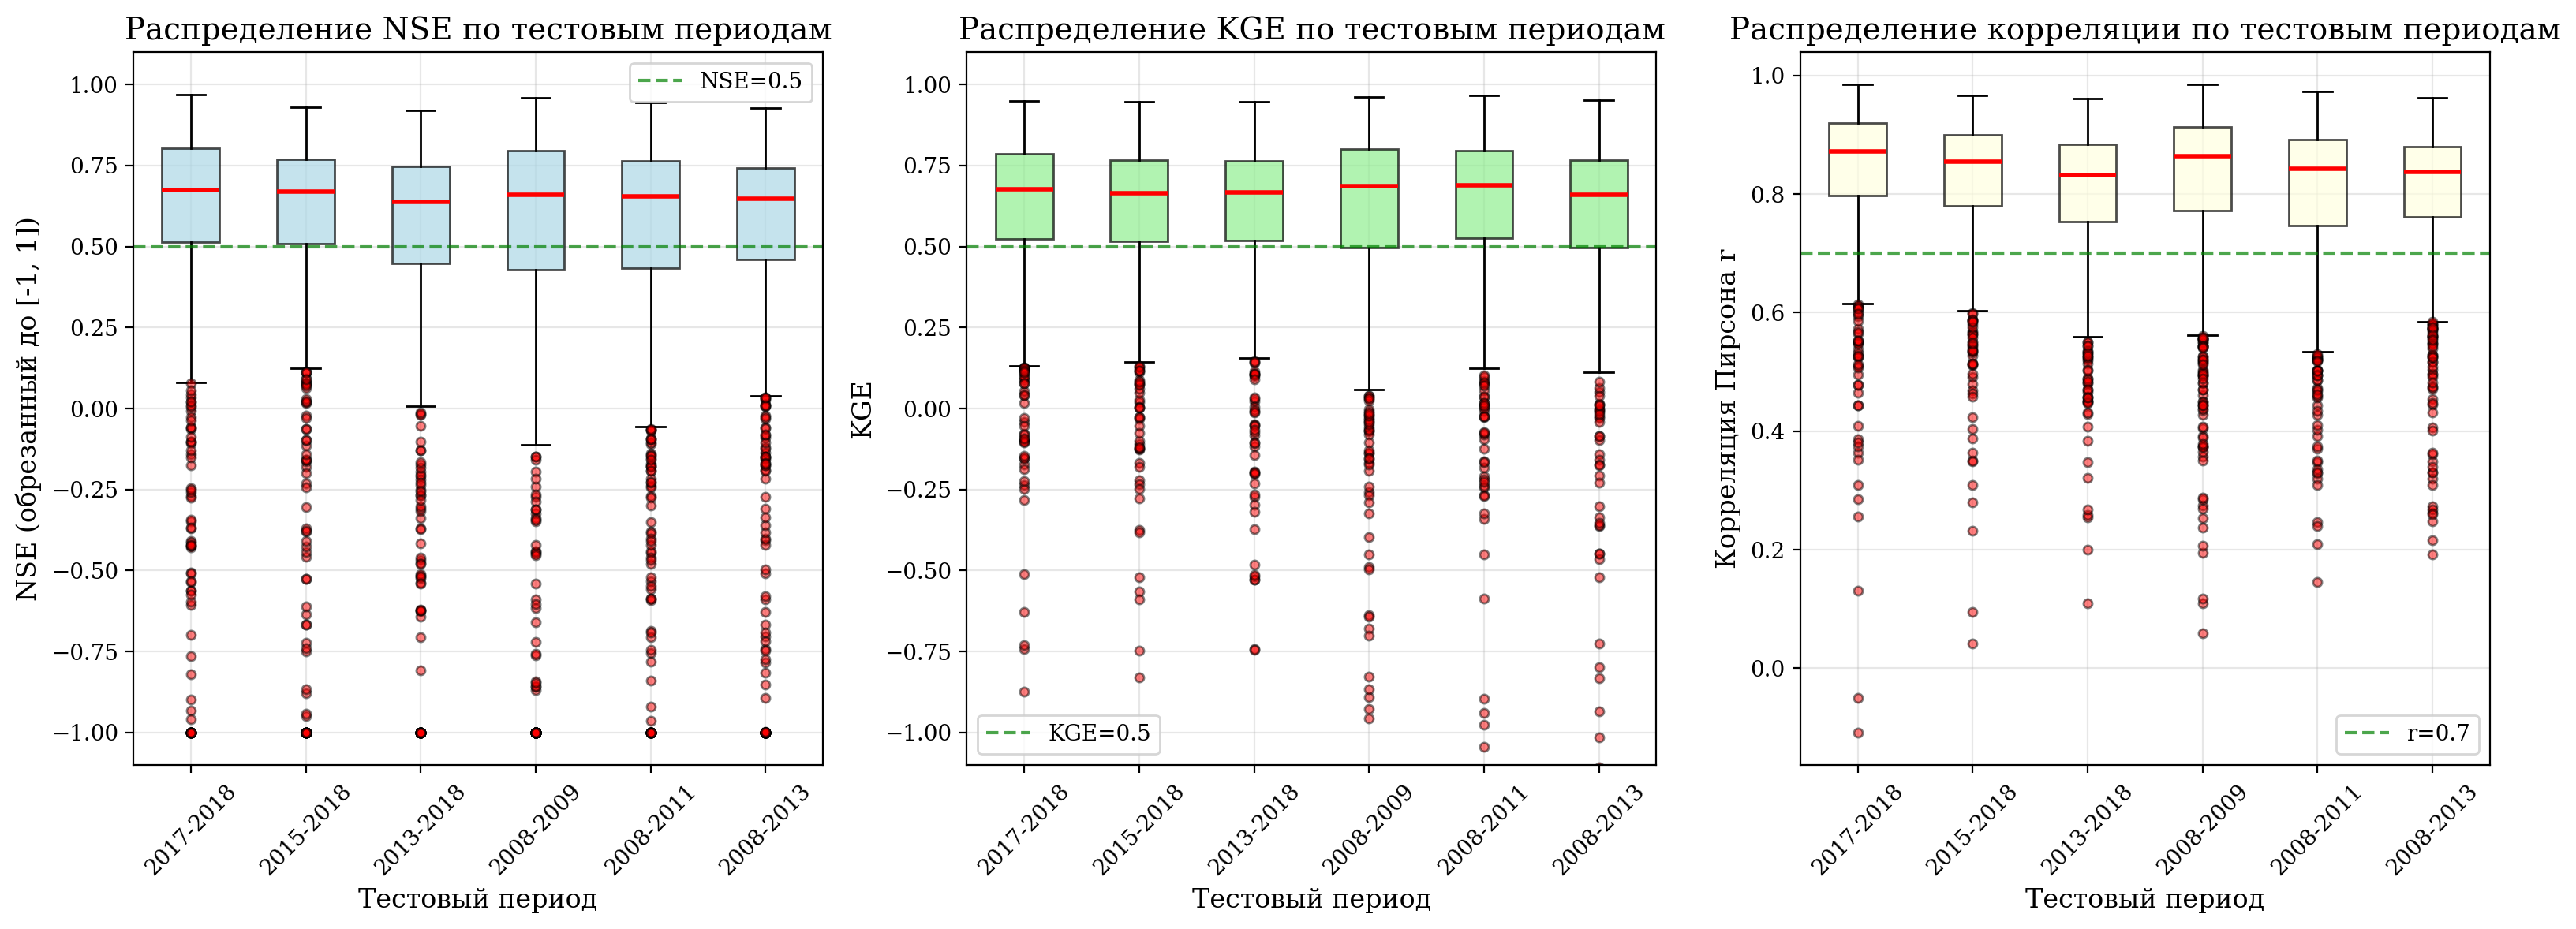

In [9]:
# All periods comparison - NSE (clipped), KGE, r boxplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Create tick labels with test years
tick_labels = [period_labels_short[p] for p in test_periods]

# NSE boxplot (using clipped values for visualization)
nse_data = [metrics_wide["NSE_clipped"][period].dropna() for period in test_periods]
bp1 = axes[0].boxplot(
    nse_data,
    tick_labels=tick_labels,
    patch_artist=True,
    boxprops={"facecolor": "lightblue", "alpha": 0.7},
    medianprops={"color": "red", "linewidth": 2},
    flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 4, "alpha": 0.5},
)
axes[0].axhline(y=0.5, color="green", linestyle="--", alpha=0.7, label="NSE=0.5")
axes[0].set_ylabel("NSE (обрезанный до [-1, 1])", fontsize=12)
axes[0].set_xlabel("Тестовый период", fontsize=12)
axes[0].set_title("Распределение NSE по тестовым периодам", fontsize=14)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)

# KGE boxplot
kge_data = [metrics_wide["KGE"][period].dropna() for period in test_periods]
bp2 = axes[1].boxplot(
    kge_data,
    tick_labels=tick_labels,
    patch_artist=True,
    boxprops={"facecolor": "lightgreen", "alpha": 0.7},
    medianprops={"color": "red", "linewidth": 2},
    flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 4, "alpha": 0.5},
)
axes[1].axhline(y=0.5, color="green", linestyle="--", alpha=0.7, label="KGE=0.5")
axes[1].set_ylabel("KGE", fontsize=12)
axes[1].set_xlabel("Тестовый период", fontsize=12)
axes[1].set_title("Распределение KGE по тестовым периодам", fontsize=14)
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)

# r (Pearson correlation) boxplot
r_data = [metrics_wide["r"][period].dropna() for period in test_periods]
bp3 = axes[2].boxplot(
    r_data,
    tick_labels=tick_labels,
    patch_artist=True,
    boxprops={"facecolor": "lightyellow", "alpha": 0.7},
    medianprops={"color": "red", "linewidth": 2},
    flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 4, "alpha": 0.5},
)
axes[2].axhline(y=0.7, color="green", linestyle="--", alpha=0.7, label="r=0.7")
axes[2].set_ylabel("Корреляция Пирсона r", fontsize=12)
axes[2].set_xlabel("Тестовый период", fontsize=12)
axes[2].set_title("Распределение корреляции по тестовым периодам", fontsize=14)
axes[2].tick_params(axis="x", rotation=45)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

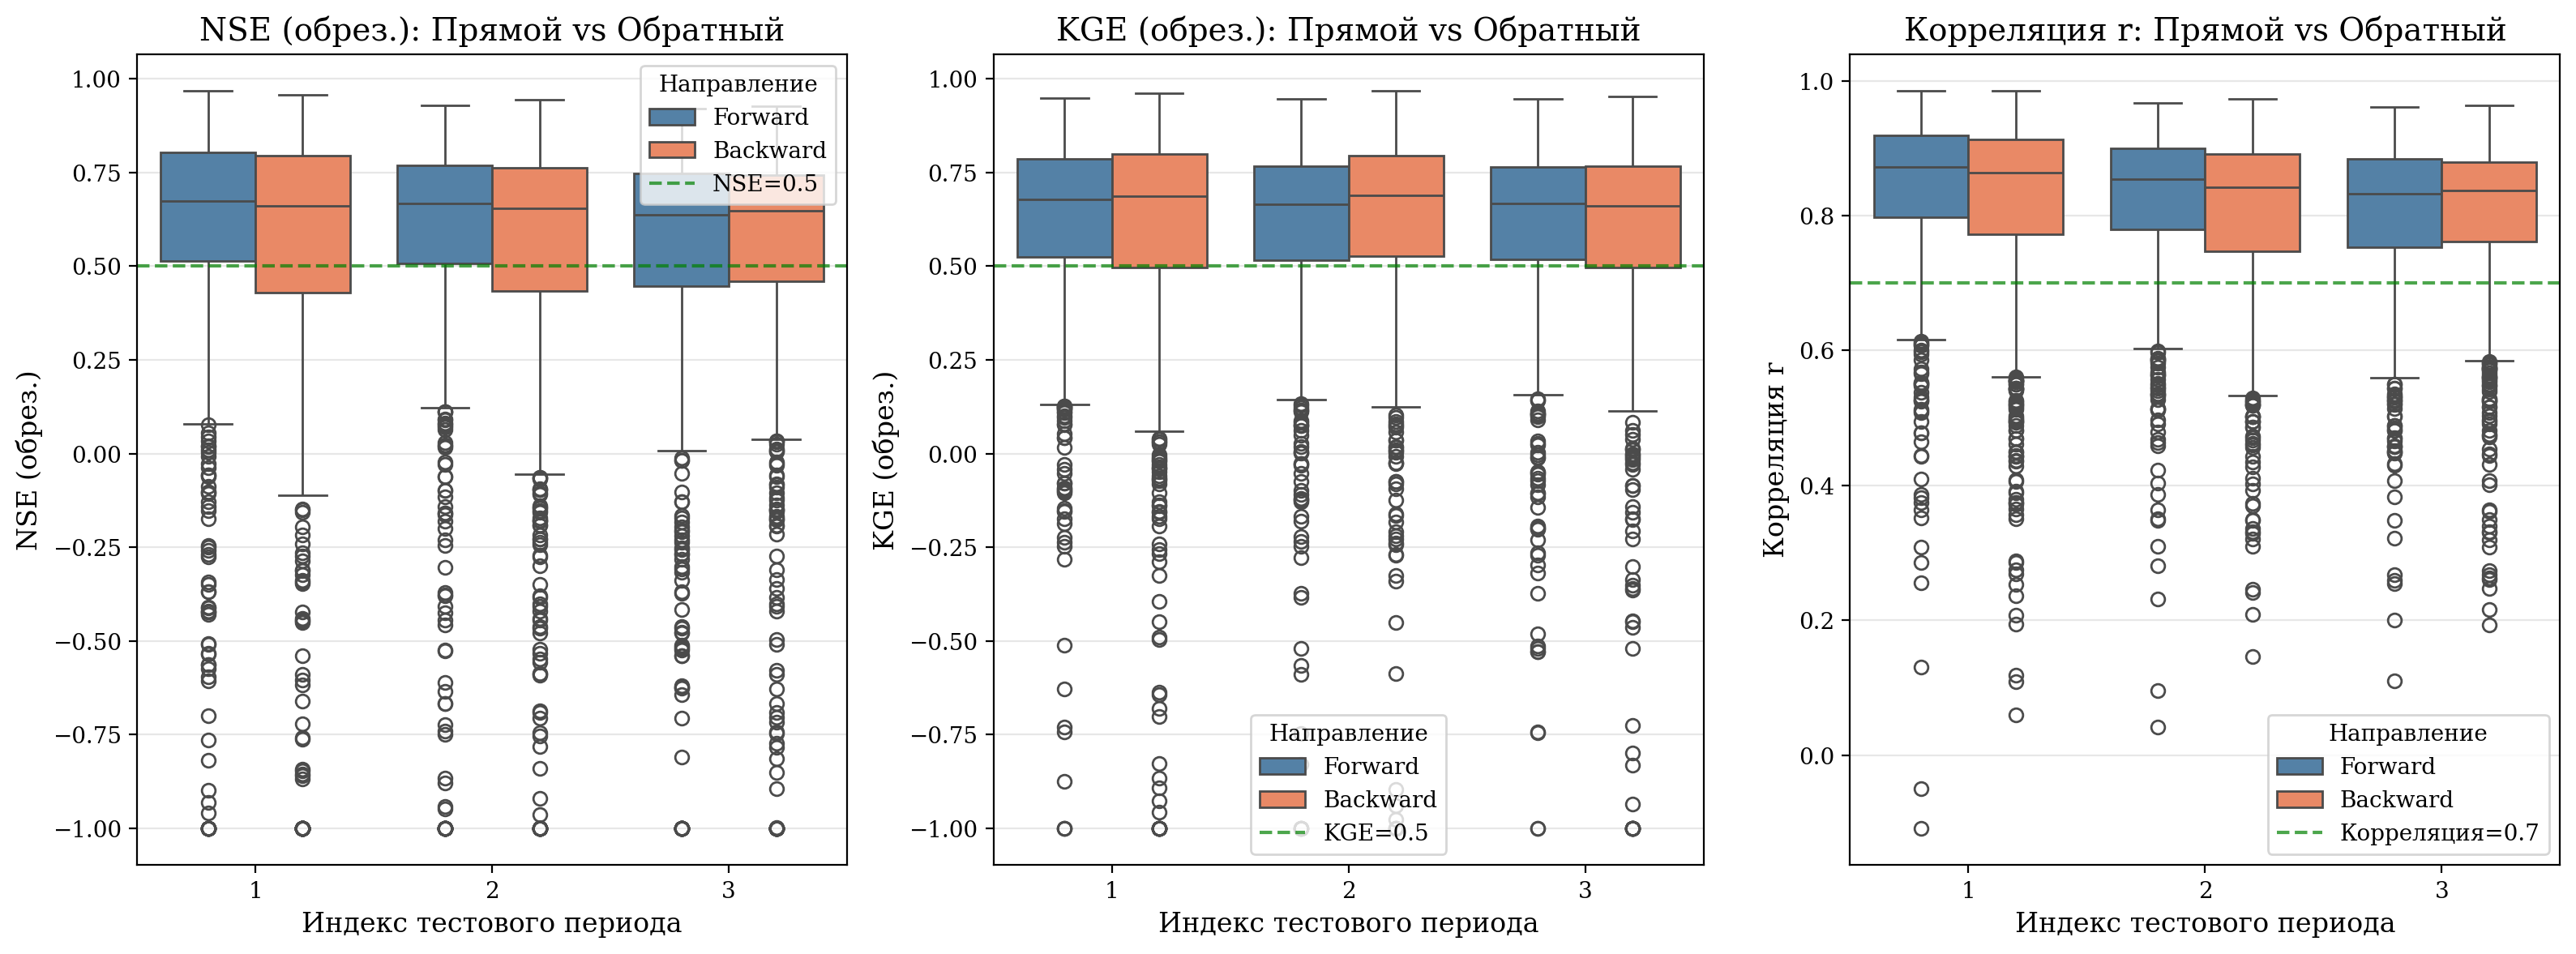

In [10]:
# Forward vs Backward comparison - grouped boxplots for NSE, KGE, r
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Prepare data for grouped comparison
metrics_df["direction"] = metrics_df["period"].apply(
    lambda x: "Forward" if x.startswith("forward") else "Backward"
)
metrics_df["period_length"] = metrics_df["period"].apply(lambda x: int(x.split("_")[1]))

# Add clipped NSE to metrics_df for visualization
metrics_df["NSE_clipped"] = metrics_df["NSE"].clip(lower=-1, upper=1)
# Add clipped NSE to metrics_df for visualization
metrics_df["KGE_clipped"] = metrics_df["KGE"].clip(lower=-1, upper=1)
# Colors for directions
colors = {"Forward": "steelblue", "Backward": "coral"}

# Define metrics and their thresholds (with Russian labels)
plot_metrics = [
    ("NSE_clipped", "NSE (обрез.)", 0.5),
    ("KGE_clipped", "KGE (обрез.)", 0.5),
    ("r", "Корреляция r", 0.7),
]

for i, (metric, label, threshold) in enumerate(plot_metrics):
    ax = axes[i]

    # Create grouped boxplot using seaborn
    sns.boxplot(
        data=metrics_df,
        x="period_length",
        y=metric,
        hue="direction",
        palette=colors,
        ax=ax,
    )

    ax.axhline(
        y=threshold,
        color="green",
        linestyle="--",
        alpha=0.7,
        label=f"{label.split()[0]}={threshold}",
    )
    ax.set_xlabel("Индекс тестового периода", fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(f"{label}: Прямой vs Обратный", fontsize=14)
    ax.legend(title="Направление")
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

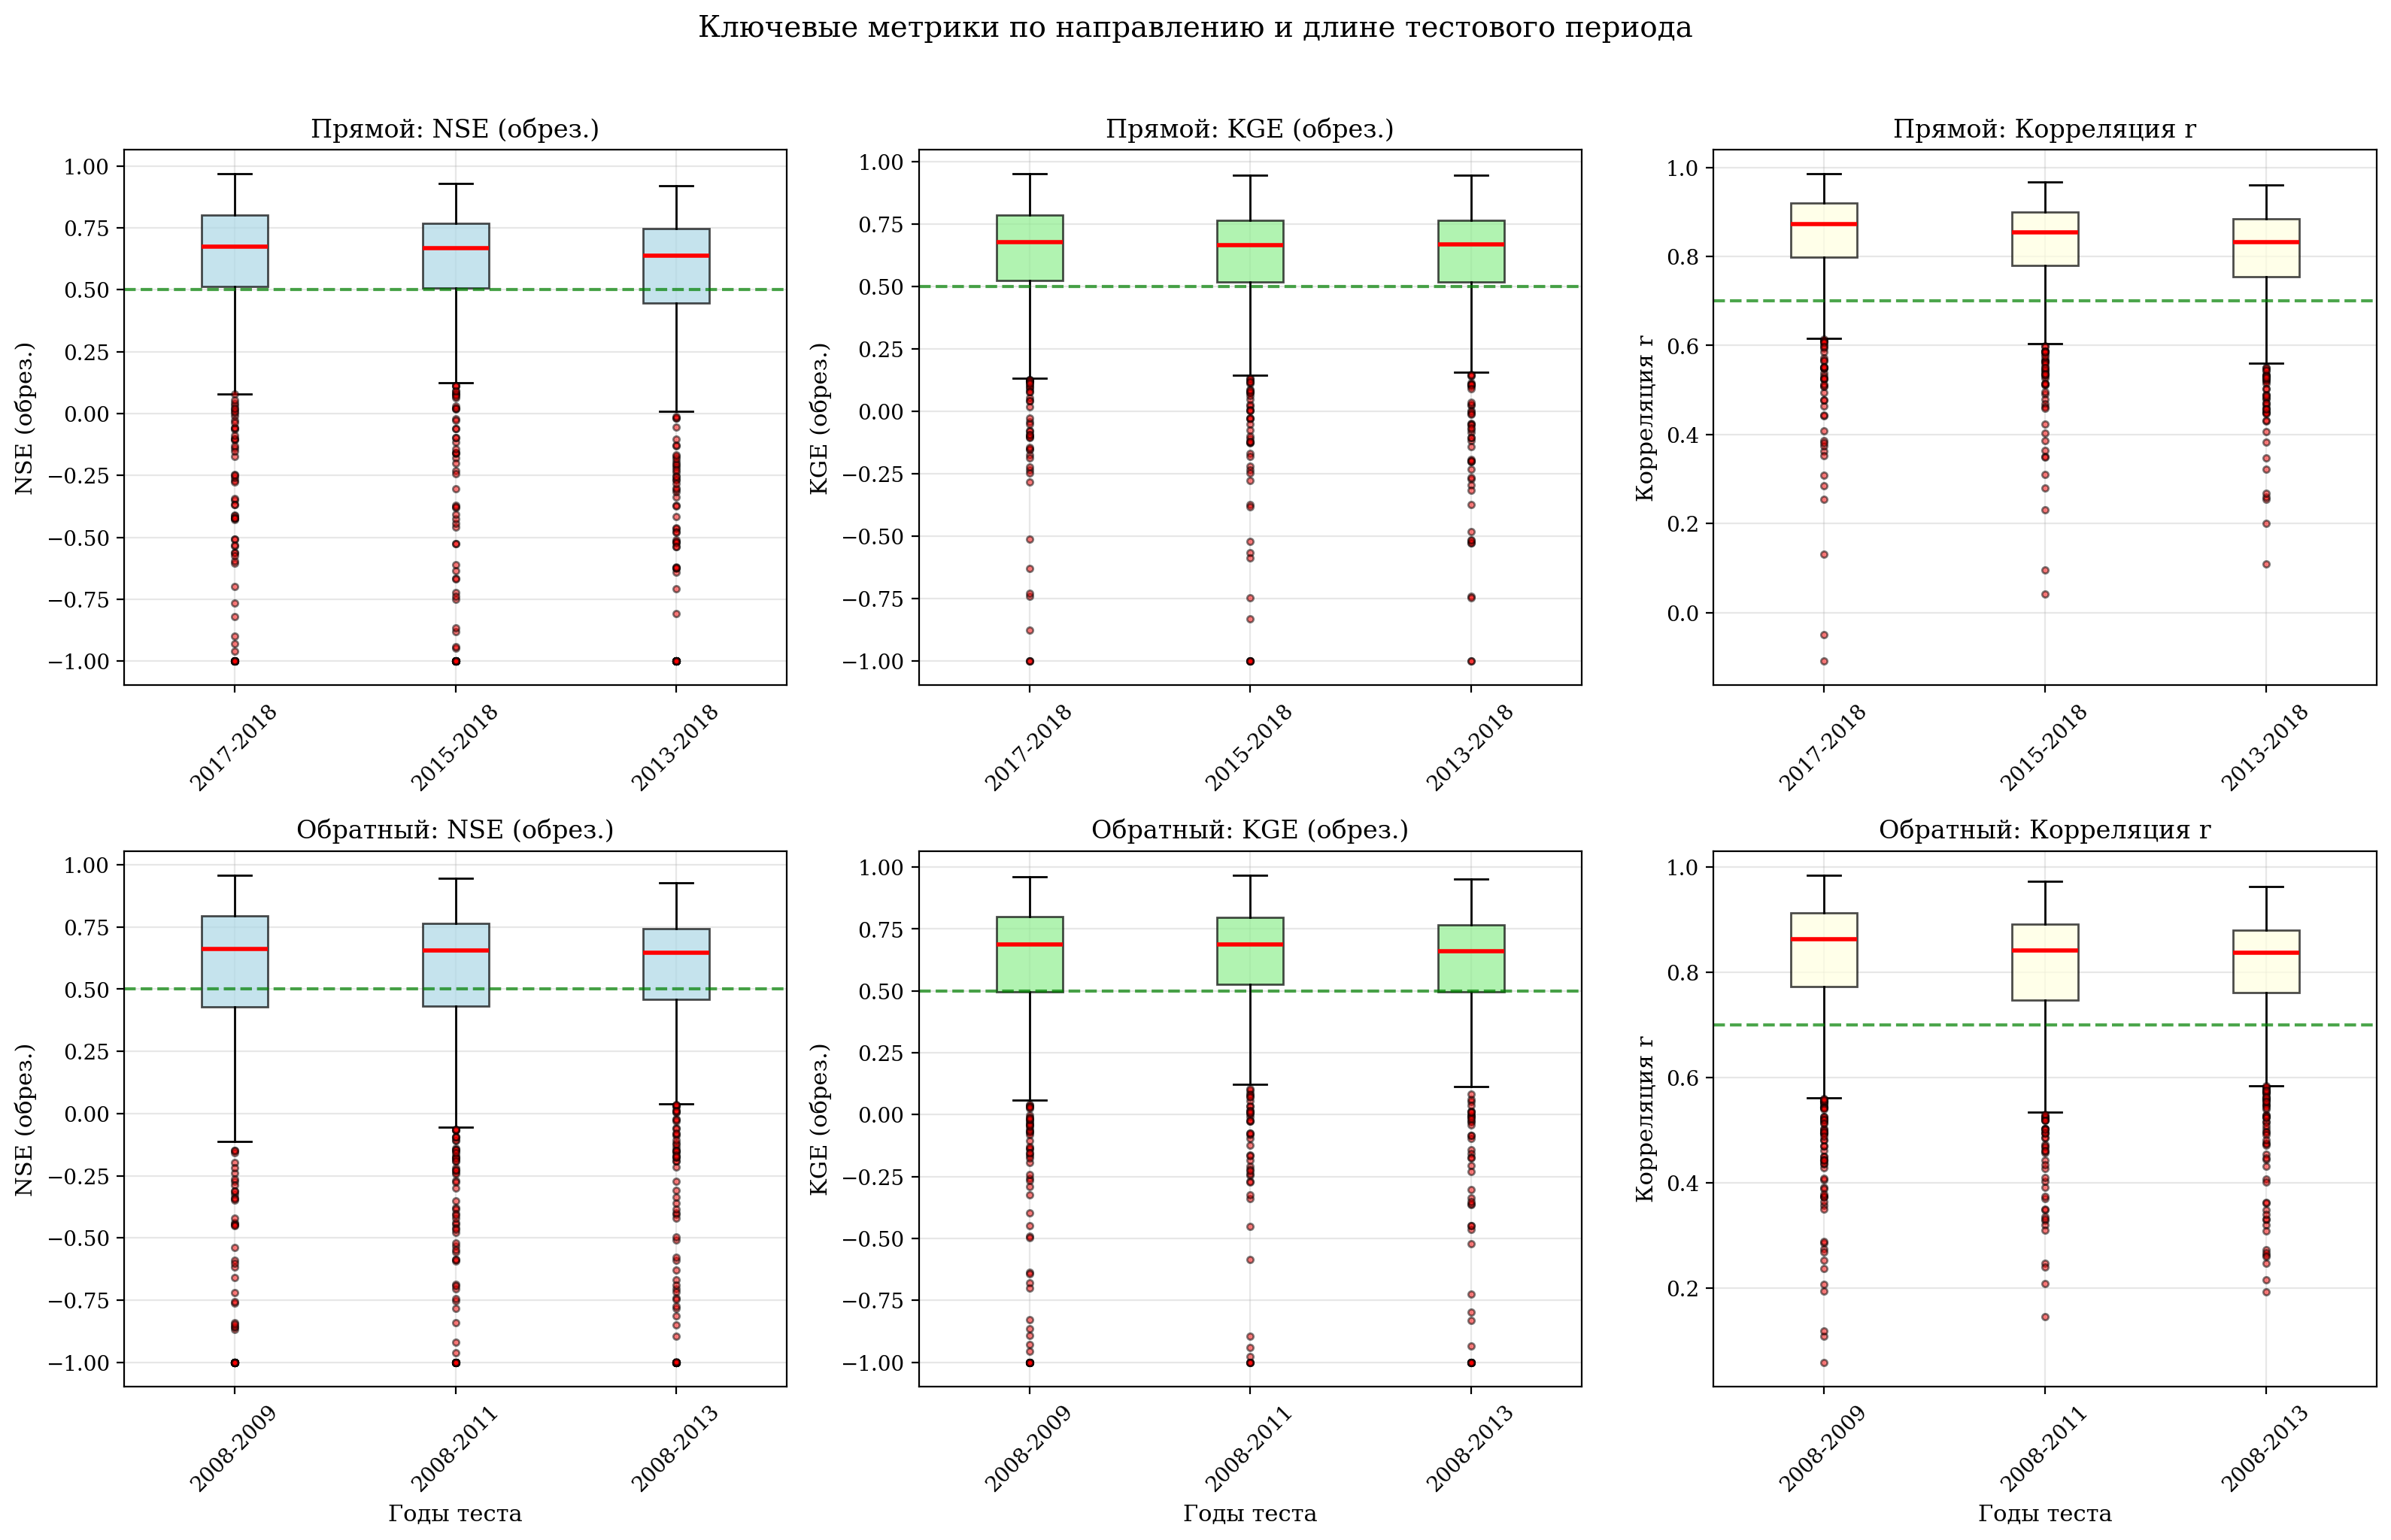

In [11]:
# Detailed comparison: 3 key metrics across forward and backward periods separately
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Create tick labels
forward_labels = [period_labels_short[p] for p in forward_periods]
backward_labels = [period_labels_short[p] for p in backward_periods]

# Define metrics configuration (with Russian labels)
metric_config = [
    ("NSE_clipped", "NSE (обрез.)", "lightblue", 0.5),
    ("KGE_clipped", "KGE (обрез.)", "lightgreen", 0.5),
    ("r", "Корреляция r", "lightyellow", 0.7),
]

# Forward periods (top row)
for i, (metric, label, color, threshold) in enumerate(metric_config):
    ax = axes[0, i]
    metric_data = [metrics_wide[metric][period].dropna() for period in forward_periods]

    bp = ax.boxplot(
        metric_data,
        tick_labels=forward_labels,
        patch_artist=True,
        boxprops={"facecolor": color, "alpha": 0.7},
        medianprops={"color": "red", "linewidth": 2},
        flierprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markersize": 3,
            "alpha": 0.5,
        },
    )
    ax.axhline(y=threshold, color="green", linestyle="--", alpha=0.7)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f"Прямой: {label}", fontsize=12)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, alpha=0.3)

# Backward periods (bottom row)
for i, (metric, label, color, threshold) in enumerate(metric_config):
    ax = axes[1, i]
    metric_data = [metrics_wide[metric][period].dropna() for period in backward_periods]

    bp = ax.boxplot(
        metric_data,
        tick_labels=backward_labels,
        patch_artist=True,
        boxprops={"facecolor": color, "alpha": 0.7},
        medianprops={"color": "red", "linewidth": 2},
        flierprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markersize": 3,
            "alpha": 0.5,
        },
    )
    ax.axhline(y=threshold, color="green", linestyle="--", alpha=0.7)
    ax.set_ylabel(label, fontsize=11)
    ax.set_xlabel("Годы теста", fontsize=11)
    ax.set_title(f"Обратный: {label}", fontsize=12)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Ключевые метрики по направлению и длине тестового периода", fontsize=14, y=1.02
)
plt.tight_layout()
plt.show()

## Paired Performance Analysis

In [12]:
# Compute pairwise mean differences for NSE (clipped) between all periods
nse_wide = metrics_wide["NSE_clipped"]  # Use clipped NSE for robust comparison

# Create year-based labels for display
year_labels = [period_labels_short[p] for p in test_periods]

# Create pairwise difference matrix with year labels
pairwise_diff = pd.DataFrame(index=year_labels, columns=year_labels, dtype=float)
pairwise_pvals = pd.DataFrame(index=year_labels, columns=year_labels, dtype=float)

for i, p1 in enumerate(test_periods):
    for j, p2 in enumerate(test_periods):
        # Get paired data (gauges present in both periods)
        common_idx = nse_wide[[p1, p2]].dropna().index
        v1 = nse_wide.loc[common_idx, p1]
        v2 = nse_wide.loc[common_idx, p2]

        # Mean difference (p1 - p2)
        pairwise_diff.loc[year_labels[i], year_labels[j]] = (v1 - v2).mean()

        # Wilcoxon signed-rank test (non-parametric paired test)
        if p1 != p2 and len(common_idx) > 10:
            try:
                stat, pval = stats.wilcoxon(v1, v2, alternative="two-sided")
                pairwise_pvals.loc[year_labels[i], year_labels[j]] = pval
            except Exception:
                pairwise_pvals.loc[year_labels[i], year_labels[j]] = np.nan
        else:
            pairwise_pvals.loc[year_labels[i], year_labels[j]] = np.nan

print("Pairwise Mean NSE Differences (clipped, row - column):")
pairwise_diff.round(4)

Pairwise Mean NSE Differences (clipped, row - column):


2017-2018  2015-2018  2013-2018  2008-2009  2008-2011  2008-2013
2017-2018     0.0000     0.0182     0.0561     0.0602     0.0559     0.0559
2015-2018    -0.0182     0.0000     0.0379     0.0421     0.0378     0.0378
2013-2018    -0.0561    -0.0379     0.0000     0.0041    -0.0002    -0.0002
2008-2009    -0.0602    -0.0421    -0.0041     0.0000    -0.0043    -0.0043
2008-2011    -0.0559    -0.0378     0.0002     0.0043     0.0000     0.0000
2008-2013    -0.0559    -0.0378     0.0002     0.0043    -0.0000     0.0000

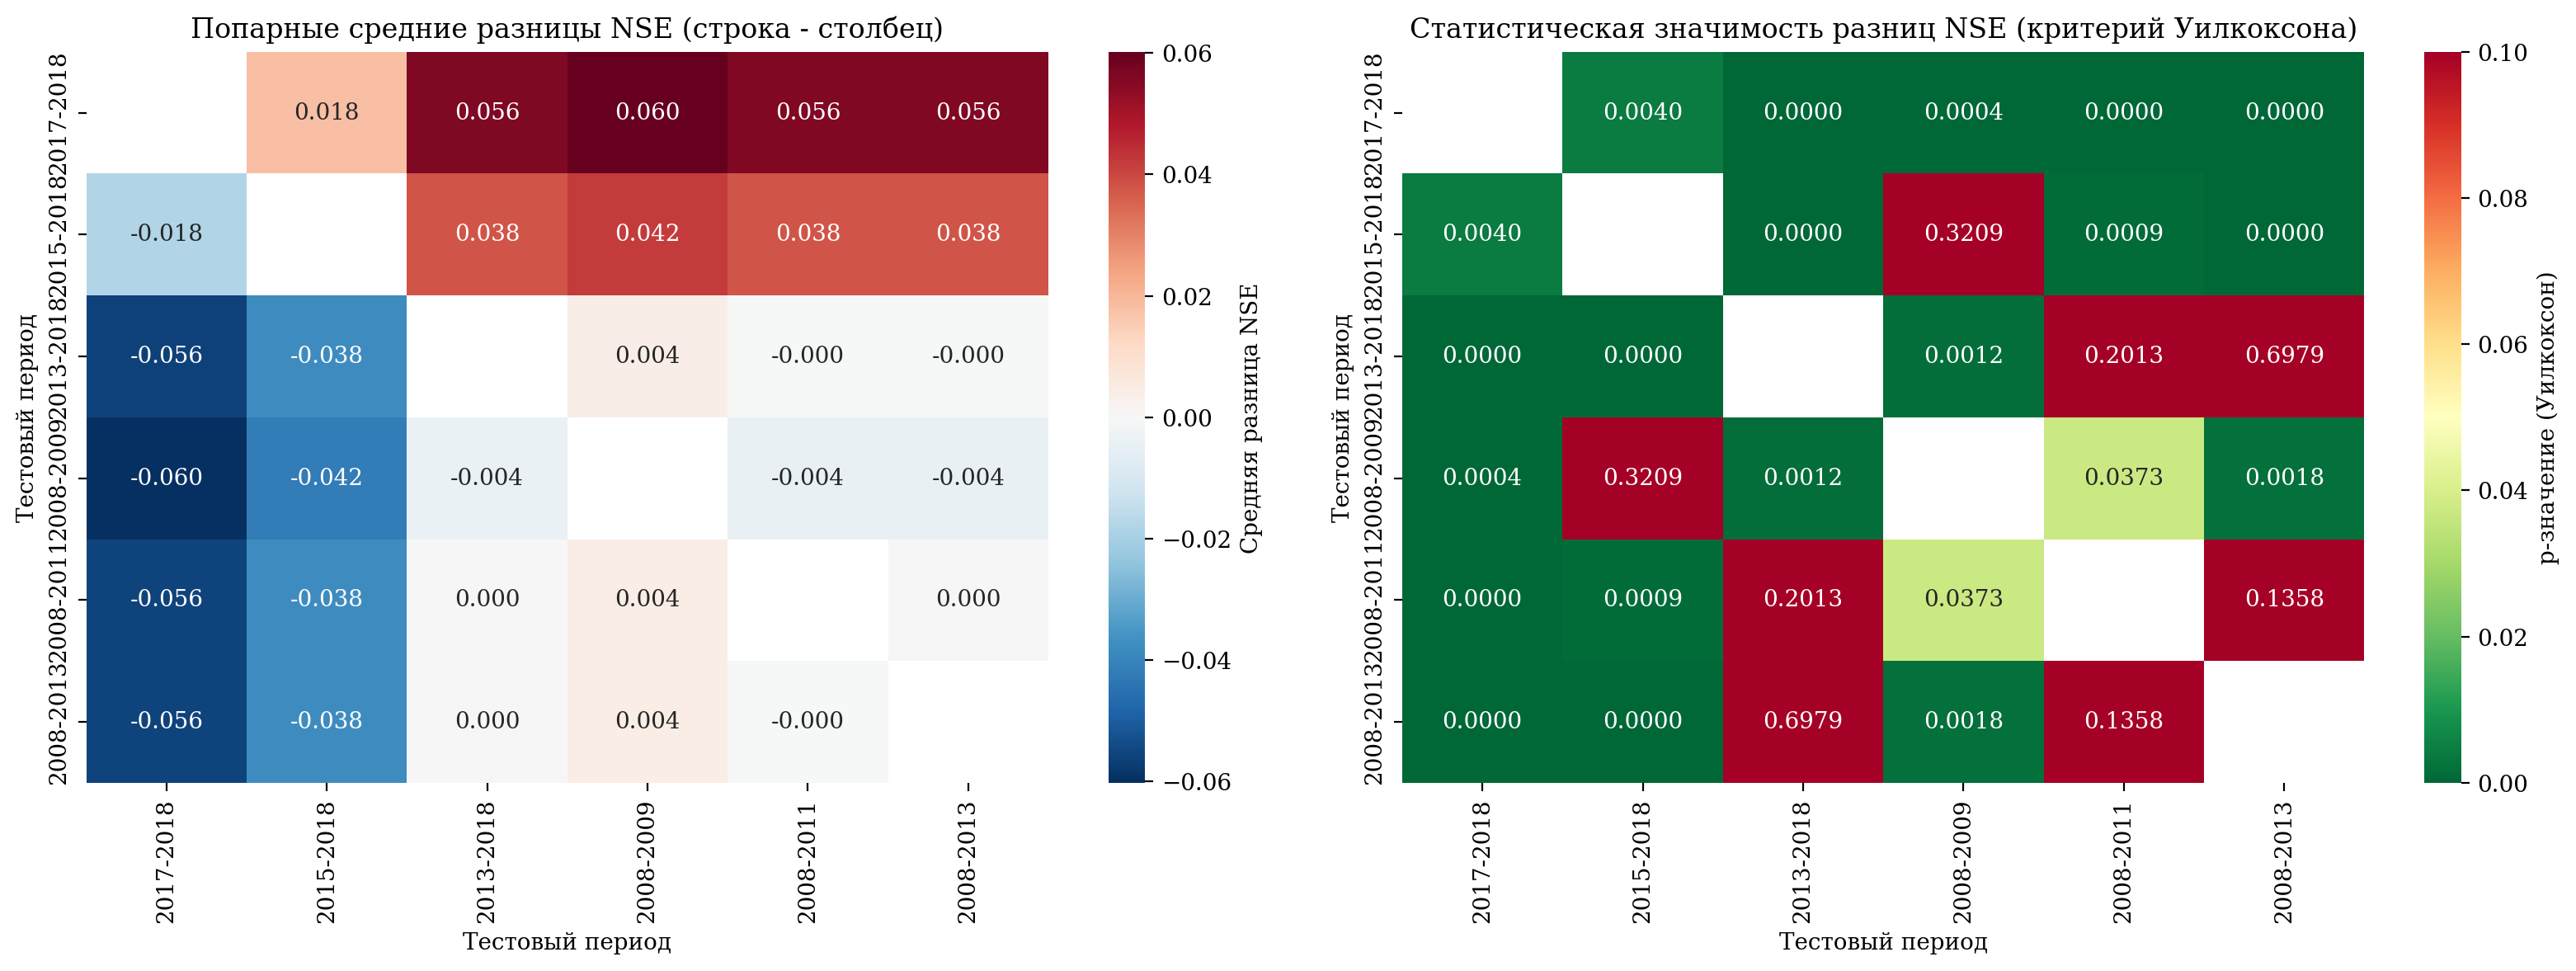


Statistically significant NSE differences (p < 0.05):
  2017-2018 vs 2015-2018: diff=0.0182, p=0.0040
  2017-2018 vs 2013-2018: diff=0.0561, p=0.0000
  2017-2018 vs 2008-2009: diff=0.0602, p=0.0004
  2017-2018 vs 2008-2011: diff=0.0559, p=0.0000
  2017-2018 vs 2008-2013: diff=0.0559, p=0.0000
  2015-2018 vs 2017-2018: diff=-0.0182, p=0.0040
  2015-2018 vs 2013-2018: diff=0.0379, p=0.0000
  2015-2018 vs 2008-2011: diff=0.0378, p=0.0009
  2015-2018 vs 2008-2013: diff=0.0378, p=0.0000
  2013-2018 vs 2017-2018: diff=-0.0561, p=0.0000
  2013-2018 vs 2015-2018: diff=-0.0379, p=0.0000
  2013-2018 vs 2008-2009: diff=0.0041, p=0.0012
  2008-2009 vs 2017-2018: diff=-0.0602, p=0.0004
  2008-2009 vs 2013-2018: diff=-0.0041, p=0.0012
  2008-2009 vs 2008-2011: diff=-0.0043, p=0.0373
  2008-2009 vs 2008-2013: diff=-0.0043, p=0.0018
  2008-2011 vs 2017-2018: diff=-0.0559, p=0.0000
  2008-2011 vs 2015-2018: diff=-0.0378, p=0.0009
  2008-2011 vs 2008-2009: diff=0.0043, p=0.0373
  2008-2013 vs 2017-2018

In [13]:
# Heatmap of pairwise NSE (clipped) differences
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Difference heatmap
ax1 = axes[0]
mask = np.zeros_like(pairwise_diff.astype(float), dtype=bool)
np.fill_diagonal(mask, True)

sns.heatmap(
    pairwise_diff.astype(float),
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",
    center=0,
    mask=mask,
    ax=ax1,
    cbar_kws={"label": "Средняя разница NSE"},
)
ax1.set_title("Попарные средние разницы NSE (строка - столбец)", fontsize=12)
ax1.set_xlabel("Тестовый период")
ax1.set_ylabel("Тестовый период")

# P-value heatmap (significance)
ax2 = axes[1]
pval_display = pairwise_pvals.astype(float).copy()

sns.heatmap(
    pval_display,
    annot=True,
    fmt=".4f",
    cmap="RdYlGn_r",
    vmin=0,
    vmax=0.1,
    mask=mask,
    ax=ax2,
    cbar_kws={"label": "p-значение (Уилкоксон)"},
)
ax2.set_title("Статистическая значимость разниц NSE (критерий Уилкоксона)", fontsize=12)
ax2.set_xlabel("Тестовый период")
ax2.set_ylabel("Тестовый период")

plt.tight_layout()
plt.show()

# Print significant differences
print("\nStatistically significant NSE differences (p < 0.05):")
for i, p1 in enumerate(test_periods):
    for j, p2 in enumerate(test_periods):
        if p1 != p2:
            pval = pairwise_pvals.loc[year_labels[i], year_labels[j]]
            if pd.notna(pval) and pval < 0.05:
                diff = pairwise_diff.loc[year_labels[i], year_labels[j]]
                print(
                    f"  {year_labels[i]} vs {year_labels[j]}: diff={diff:.4f}, p={pval:.4f}"
                )

In [14]:
# Key comparisons: Forward vs Backward for same period lengths (all 3 metrics)
print("Forward vs Backward Comparisons (same period length) - NSE, KGE, r:")
print("=" * 80)

comparison_results = []
period_pairs = [
    ("forward_1", "back_1", "2 years"),
    ("forward_2", "back_2", "4 years"),
    ("forward_3", "back_3", "6 years"),
]

for forward_period, backward_period, duration in period_pairs:
    forward_years = period_info[forward_period]["test_years"]
    backward_years = period_info[backward_period]["test_years"]

    print(f"\n{duration}: {forward_years} (Forward) vs {backward_years} (Backward)")
    print("-" * 60)

    for metric in ["NSE_clipped", "KGE", "r"]:
        metric_wide = metrics_wide[metric]
        common_idx = metric_wide[[forward_period, backward_period]].dropna().index
        forward_vals = metric_wide.loc[common_idx, forward_period]
        backward_vals = metric_wide.loc[common_idx, backward_period]

        # Statistical test
        stat, pval = stats.wilcoxon(forward_vals, backward_vals, alternative="two-sided")

        metric_label = "NSE" if metric == "NSE_clipped" else metric

        result = {
            "duration": duration,
            "metric": metric_label,
            "forward_years": forward_years,
            "backward_years": backward_years,
            "n_pairs": len(common_idx),
            "forward_median": forward_vals.median(),
            "backward_median": backward_vals.median(),
            "diff_median": (forward_vals - backward_vals).median(),
            "p_value": pval,
            "significant": "Yes" if pval < 0.05 else "No",
        }
        comparison_results.append(result)

        sig = (
            "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        )
        print(
            f"  {metric_label:3s}: Forward={forward_vals.median():.4f}, Backward={backward_vals.median():.4f}, "
            f"Diff={result['diff_median']:.4f}, p={pval:.4f} {sig}"
        )

comparison_df = pd.DataFrame(comparison_results)
print("\n*** p<0.001, ** p<0.01, * p<0.05")
comparison_df

Forward vs Backward Comparisons (same period length) - NSE, KGE, r:

2 years: 2017-2018 (Forward) vs 2008-2009 (Backward)
------------------------------------------------------------
  NSE: Forward=0.6744, Backward=0.6605, Diff=0.0120, p=0.0004 ***
  KGE: Forward=0.6777, Backward=0.6872, Diff=-0.0013, p=0.5569 
  r  : Forward=0.8719, Backward=0.8636, Diff=0.0096, p=0.0000 ***

4 years: 2015-2018 (Forward) vs 2008-2011 (Backward)
------------------------------------------------------------
  NSE: Forward=0.6685, Backward=0.6543, Diff=0.0085, p=0.0009 ***
  KGE: Forward=0.6646, Backward=0.6885, Diff=-0.0273, p=0.0006 ***
  r  : Forward=0.8547, Backward=0.8422, Diff=0.0120, p=0.0000 ***

6 years: 2013-2018 (Forward) vs 2008-2013 (Backward)
------------------------------------------------------------
  NSE: Forward=0.6374, Backward=0.6476, Diff=-0.0021, p=0.6979 
  KGE: Forward=0.6665, Backward=0.6600, Diff=0.0100, p=0.1944 
  r  : Forward=0.8325, Backward=0.8379, Diff=-0.0013, p=0.8908 



duration metric forward_years backward_years  n_pairs  forward_median  \
0  2 years    NSE     2017-2018      2008-2009      996        0.674447   
1  2 years    KGE     2017-2018      2008-2009      996        0.677721   
2  2 years      r     2017-2018      2008-2009      996        0.871856   
3  4 years    NSE     2015-2018      2008-2011      996        0.668515   
4  4 years    KGE     2015-2018      2008-2011      996        0.664617   
5  4 years      r     2015-2018      2008-2011      996        0.854715   
6  6 years    NSE     2013-2018      2008-2013      996        0.637436   
7  6 years    KGE     2013-2018      2008-2013      996        0.666534   
8  6 years      r     2013-2018      2008-2013      996        0.832458   

   backward_median  diff_median       p_value significant  
0         0.660518     0.012014  3.584504e-04         Yes  
1         0.687214    -0.001317  5.568668e-01          No  
2         0.863560     0.009611  2.029647e-06         Yes  
3         0.654286     0.008470  9.052787e-04         Yes  
4         0.688460    -0.027335  6.443011e-04         Yes  
5         0.842217     0.012004  4.030273e-09         Yes  
6         0.647590    -0.002066  6.978736e-01          No  
7         0.659961     0.009961  1.943596e-01          No  
8         0.837943    -0.001330  8.907760e-01          No

## Performance Degradation Analysis

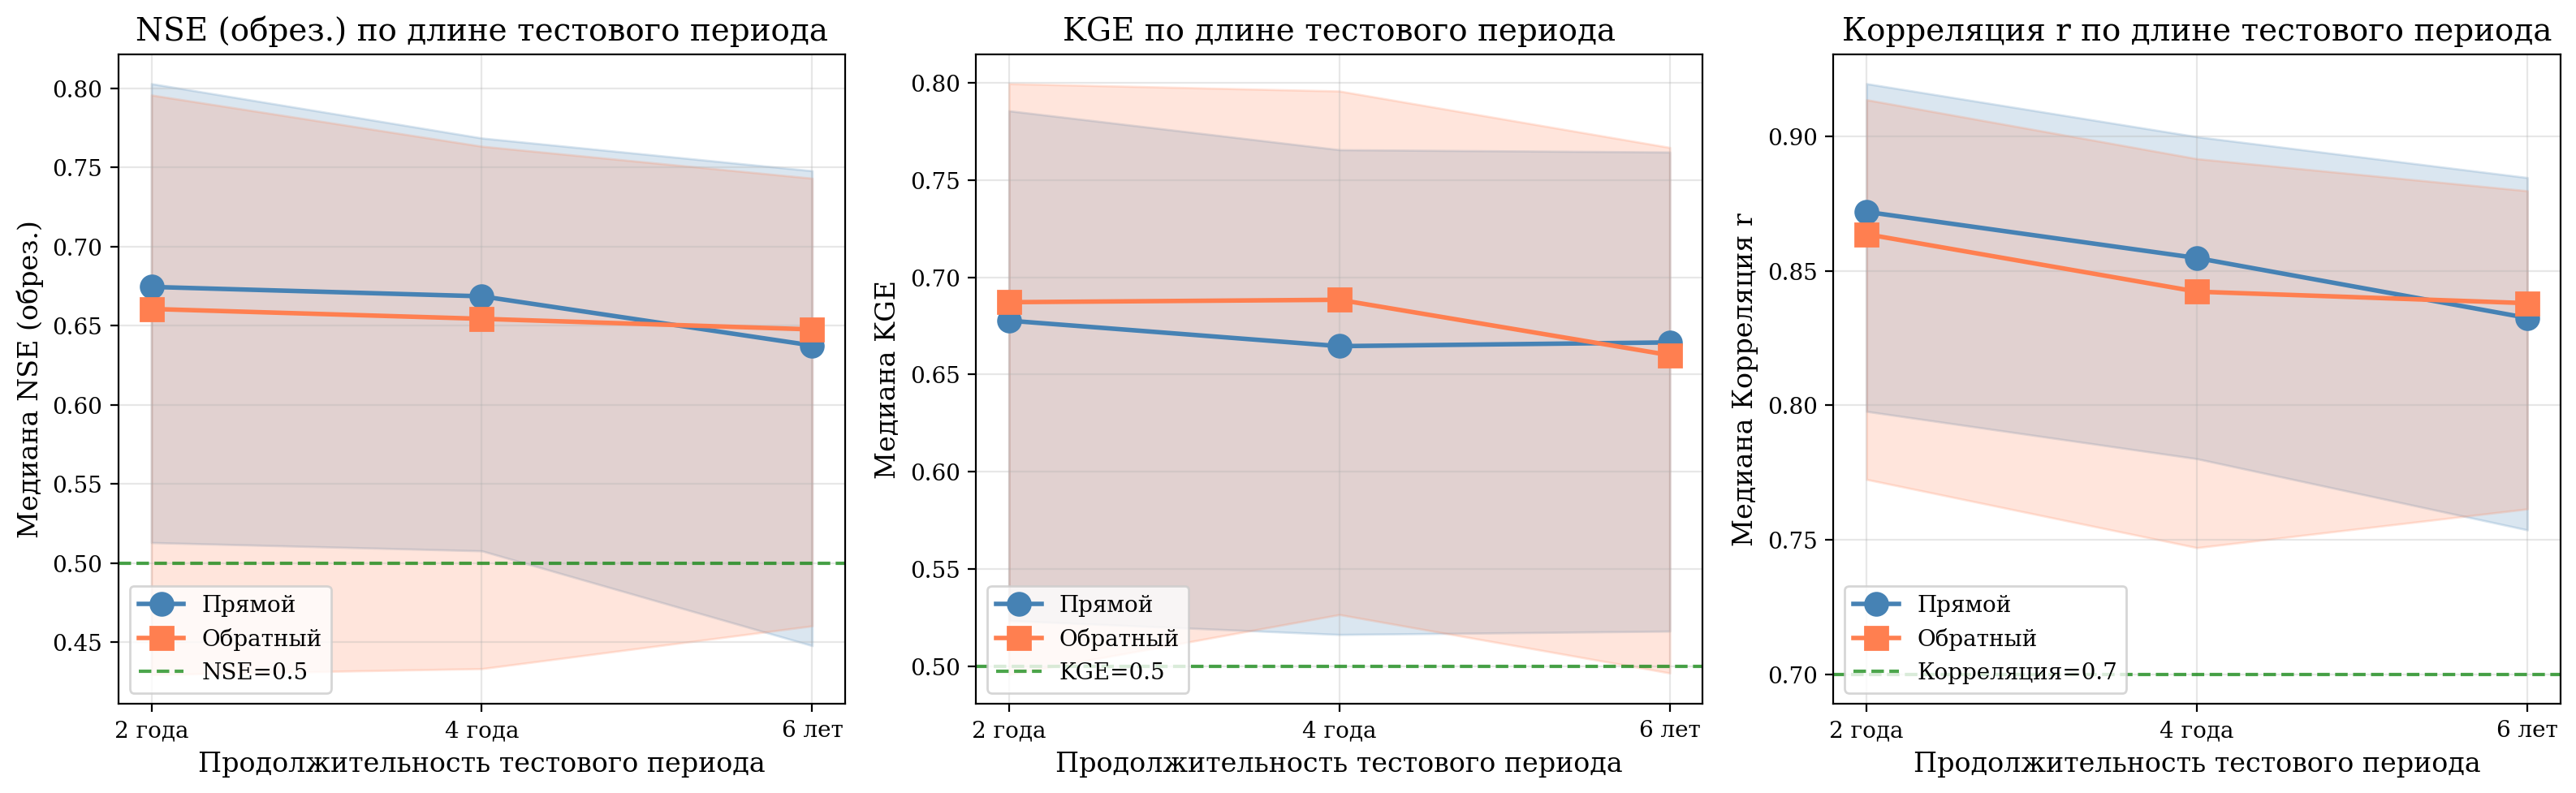

In [15]:
# Line plots showing median NSE (clipped), KGE, r vs period length
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

period_lengths = [1, 2, 3]
# X-axis labels with test years
forward_years = [period_info[f"forward_{l}"]["test_years"] for l in period_lengths]
backward_years = [period_info[f"back_{l}"]["test_years"] for l in period_lengths]

metrics_config = [
    ("NSE", "NSE (обрез.)", 0.5),
    ("KGE", "KGE", 0.5),
    ("r", "Корреляция r", 0.7),
]

for i, (metric, label, threshold) in enumerate(metrics_config):
    ax = axes[i]

    # Calculate medians for forward and backward
    forward_medians = []
    backward_medians = []
    forward_q25 = []
    forward_q75 = []
    backward_q25 = []
    backward_q75 = []

    for length in period_lengths:
        forward_vals = metrics_wide[metric][f"forward_{length}"].dropna()
        backward_vals = metrics_wide[metric][f"back_{length}"].dropna()

        forward_medians.append(forward_vals.median())
        backward_medians.append(backward_vals.median())
        forward_q25.append(forward_vals.quantile(0.25))
        forward_q75.append(forward_vals.quantile(0.75))
        backward_q25.append(backward_vals.quantile(0.25))
        backward_q75.append(backward_vals.quantile(0.75))

    # Plot lines with error bands
    ax.plot(
        period_lengths,
        forward_medians,
        "o-",
        color="steelblue",
        linewidth=2,
        markersize=10,
        label="Прямой",
    )
    ax.fill_between(
        period_lengths, forward_q25, forward_q75, alpha=0.2, color="steelblue"
    )

    ax.plot(
        period_lengths,
        backward_medians,
        "s-",
        color="coral",
        linewidth=2,
        markersize=10,
        label="Обратный",
    )
    ax.fill_between(period_lengths, backward_q25, backward_q75, alpha=0.2, color="coral")

    ax.axhline(
        y=threshold,
        color="green",
        linestyle="--",
        alpha=0.7,
        label=f"{label.split()[0]}={threshold}",
    )

    ax.set_xlabel("Продолжительность тестового периода", fontsize=12)
    ax.set_ylabel(f"Медиана {label}", fontsize=12)
    ax.set_title(f"{label} по длине тестового периода", fontsize=14)
    ax.set_xticks(period_lengths)
    ax.set_xticklabels(["2 года", "4 года", "6 лет"])
    ax.legend(loc="lower left")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

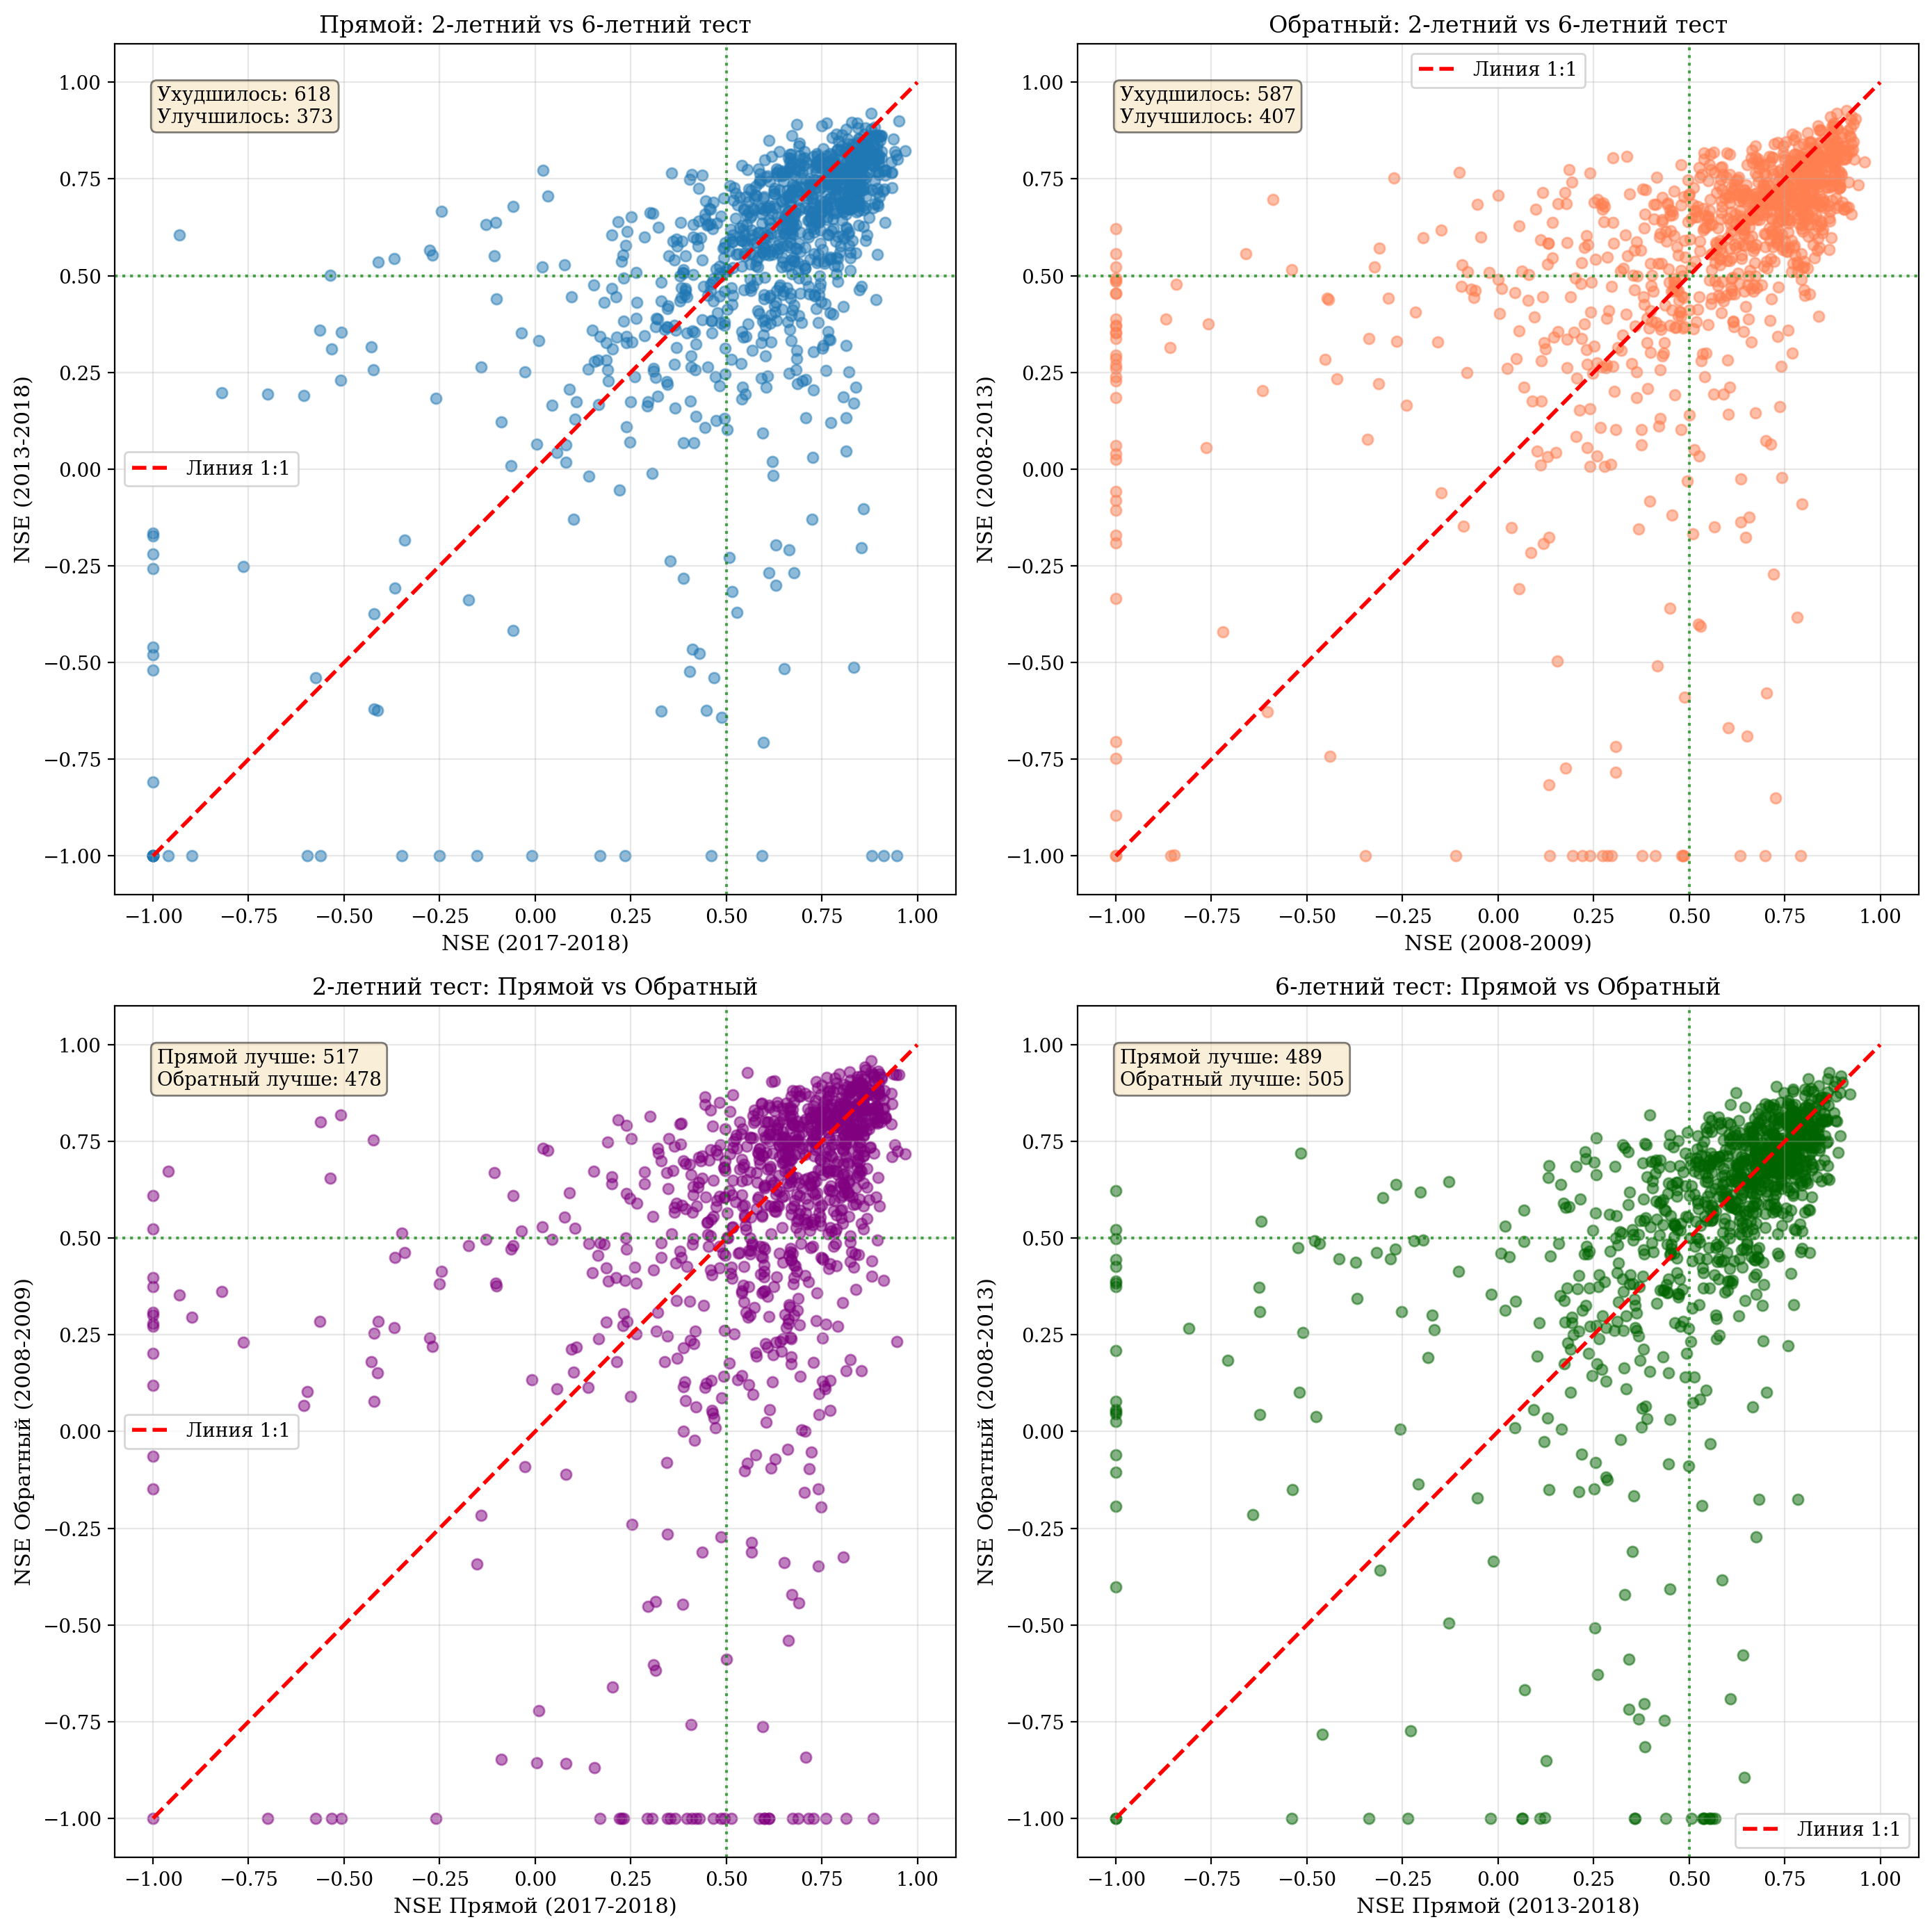

In [16]:
# Scatter plots: Short vs Long period performance using clipped NSE
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

nse_clip = metrics_wide["NSE_clipped"]  # Use clipped values

# Forward 2yr vs Forward 6yr
ax = axes[0, 0]
common_idx = nse_clip[["forward_1", "forward_3"]].dropna().index
x = nse_clip.loc[common_idx, "forward_1"]
y = nse_clip.loc[common_idx, "forward_3"]
ax.scatter(x, y, alpha=0.5, s=30)
ax.plot([-1, 1], [-1, 1], "r--", linewidth=2, label="Линия 1:1")
ax.axhline(y=0.5, color="green", linestyle=":", alpha=0.7)
ax.axvline(x=0.5, color="green", linestyle=":", alpha=0.7)
ax.set_xlabel(f"NSE ({period_info['forward_1']['test_years']})", fontsize=11)
ax.set_ylabel(f"NSE ({period_info['forward_3']['test_years']})", fontsize=11)
ax.set_title("Прямой: 2-летний vs 6-летний тест", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

# Calculate degradation stats
degraded = (y < x).sum()
improved = (y > x).sum()
ax.text(
    0.05,
    0.95,
    f"Ухудшилось: {degraded}\nУлучшилось: {improved}",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# Backward 2yr vs Backward 6yr
ax = axes[0, 1]
common_idx = nse_clip[["back_1", "back_3"]].dropna().index
x = nse_clip.loc[common_idx, "back_1"]
y = nse_clip.loc[common_idx, "back_3"]
ax.scatter(x, y, alpha=0.5, s=30, color="coral")
ax.plot([-1, 1], [-1, 1], "r--", linewidth=2, label="Линия 1:1")
ax.axhline(y=0.5, color="green", linestyle=":", alpha=0.7)
ax.axvline(x=0.5, color="green", linestyle=":", alpha=0.7)
ax.set_xlabel(f"NSE ({period_info['back_1']['test_years']})", fontsize=11)
ax.set_ylabel(f"NSE ({period_info['back_3']['test_years']})", fontsize=11)
ax.set_title("Обратный: 2-летний vs 6-летний тест", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

degraded = (y < x).sum()
improved = (y > x).sum()
ax.text(
    0.05,
    0.95,
    f"Ухудшилось: {degraded}\nУлучшилось: {improved}",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# Forward vs Back (2yr periods)
ax = axes[1, 0]
common_idx = nse_clip[["forward_1", "back_1"]].dropna().index
x = nse_clip.loc[common_idx, "forward_1"]
y = nse_clip.loc[common_idx, "back_1"]
ax.scatter(x, y, alpha=0.5, s=30, color="purple")
ax.plot([-1, 1], [-1, 1], "r--", linewidth=2, label="Линия 1:1")
ax.axhline(y=0.5, color="green", linestyle=":", alpha=0.7)
ax.axvline(x=0.5, color="green", linestyle=":", alpha=0.7)
ax.set_xlabel(f"NSE Прямой ({period_info['forward_1']['test_years']})", fontsize=11)
ax.set_ylabel(f"NSE Обратный ({period_info['back_1']['test_years']})", fontsize=11)
ax.set_title("2-летний тест: Прямой vs Обратный", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

forward_better = (x > y).sum()
back_better = (y > x).sum()
ax.text(
    0.05,
    0.95,
    f"Прямой лучше: {forward_better}\nОбратный лучше: {back_better}",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# Forward vs Back (6yr periods)
ax = axes[1, 1]
common_idx = nse_clip[["forward_3", "back_3"]].dropna().index
x = nse_clip.loc[common_idx, "forward_3"]
y = nse_clip.loc[common_idx, "back_3"]
ax.scatter(x, y, alpha=0.5, s=30, color="darkgreen")
ax.plot([-1, 1], [-1, 1], "r--", linewidth=2, label="Линия 1:1")
ax.axhline(y=0.5, color="green", linestyle=":", alpha=0.7)
ax.axvline(x=0.5, color="green", linestyle=":", alpha=0.7)
ax.set_xlabel(f"NSE Прямой ({period_info['forward_3']['test_years']})", fontsize=11)
ax.set_ylabel(f"NSE Обратный ({period_info['back_3']['test_years']})", fontsize=11)
ax.set_title("6-летний тест: Прямой vs Обратный", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

forward_better = (x > y).sum()
back_better = (y > x).sum()
ax.text(
    0.05,
    0.95,
    f"Прямой лучше: {forward_better}\nОбратный лучше: {back_better}",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

In [17]:
# Quantify performance by period length for NSE, KGE, r
print("Performance Analysis by Test Period (NSE, KGE, r):")
print("=" * 80)

degradation_stats = []
for direction in ["forward", "backward"]:
    for length in [1, 2, 3]:
        period = f"{'forward' if direction == 'forward' else 'back'}_{length}"
        info = period_info[period]

        nse_vals = metrics_wide["NSE"][period].dropna()
        nse_clipped = metrics_wide["NSE_clipped"][period].dropna()
        kge_vals = metrics_wide["KGE"][period].dropna()
        r_vals = metrics_wide["r"][period].dropna()

        degradation_stats.append(
            {
                "direction": direction.capitalize(),
                "train_years": info["train_years"],
                "train_yrs": info["train_duration"],
                "test_years": info["test_years"],
                "test_yrs": info["test_duration"],
                "nse_median": nse_clipped.median(),
                "nse_sat_pct": (nse_vals >= 0.5).mean() * 100,
                "kge_median": kge_vals.median(),
                "kge_sat_pct": (kge_vals >= 0.5).mean() * 100,
                "r_median": r_vals.median(),
                "r_sat_pct": (r_vals >= 0.7).mean() * 100,
            }
        )

degradation_df = pd.DataFrame(degradation_stats)
print("\nMetric statistics by direction, train, and test period:")
print("Satisfactory: NSE/KGE >= 0.5, r >= 0.7")
degradation_df.round(3)

Performance Analysis by Test Period (NSE, KGE, r):

Metric statistics by direction, train, and test period:
Satisfactory: NSE/KGE >= 0.5, r >= 0.7


direction train_years  train_yrs test_years  test_yrs  nse_median  \
0   Forward   2008-2014          7  2017-2018         2       0.674   
1   Forward   2008-2012          5  2015-2018         4       0.669   
2   Forward   2008-2010          3  2013-2018         6       0.637   
3  Backward   2012-2018          7  2008-2009         2       0.661   
4  Backward   2014-2018          5  2008-2011         4       0.654   
5  Backward   2016-2018          3  2008-2013         6       0.648   

   nse_sat_pct  kge_median  kge_sat_pct  r_median  r_sat_pct  
0       75.803       0.678       76.908     0.872     90.161  
1       75.602       0.665       76.406     0.855     87.952  
2       70.181       0.667       77.309     0.832     84.237  
3       68.876       0.687       74.498     0.864     83.635  
4       68.574       0.688       77.610     0.842     82.530  
5       70.482       0.660       74.398     0.838     84.137

## Example Time Series Visualizations

In [18]:
# Select representative gauges based on average NSE (clipped) across all periods
avg_nse = metrics_wide["NSE_clipped"].mean(axis=1).dropna()

# Find best, median, and worst performers
best_gauge = avg_nse.idxmax()
worst_gauge = avg_nse.idxmin()
median_gauge = avg_nse.iloc[(avg_nse.values - avg_nse.median()).argsort()[:1]].index[0]

print("Selected Representative Gauges (based on clipped NSE):")
print(f"  Best performer: {best_gauge} (avg NSE: {avg_nse[best_gauge]:.3f})")
print(f"  Median performer: {median_gauge} (avg NSE: {avg_nse[median_gauge]:.3f})")
print(f"  Worst performer: {worst_gauge} (avg NSE: {avg_nse[worst_gauge]:.3f})")

representative_gauges = [best_gauge, median_gauge, worst_gauge]
gauge_labels = ["Best", "Median", "Worst"]

Selected Representative Gauges (based on clipped NSE):
  Best performer: 10478 (avg NSE: 0.919)
  Median performer: 84011 (avg NSE: -0.674)
  Worst performer: 84011 (avg NSE: -0.674)


In [19]:
def plot_gauge_timeseries(gauge_id, periods_to_plot=None):
    """Plot observed vs simulated time series for a gauge across multiple periods."""
    if periods_to_plot is None:
        periods_to_plot = test_periods

    n_periods = len(periods_to_plot)
    fig, axes = plt.subplots(n_periods, 1, figsize=(14, 3 * n_periods), sharex=False)

    if n_periods == 1:
        axes = [axes]

    for i, period in enumerate(periods_to_plot):
        ax = axes[i]

        file_path = (
            predictions_path / str(gauge_id) / f"{gauge_id}_{period}_predictions.csv"
        )

        if not file_path.exists():
            ax.text(
                0.5,
                0.5,
                "Данные недоступны",
                transform=ax.transAxes,
                ha="center",
                va="center",
            )
            continue

        data_df = pd.read_csv(file_path, index_col="date", parse_dates=True)

        # Get metrics for this gauge-period (clipped NSE for display)
        nse = metrics_wide["NSE_clipped"].loc[gauge_id, period]
        kge = metrics_wide["KGE"].loc[gauge_id, period]
        r = metrics_wide["r"].loc[gauge_id, period]
        test_years = period_info[period]["test_years"]
        direction = period_info[period]["direction"]
        direction_ru = "Прямой" if "forward" in period else "Обратный"

        # Plot
        ax.plot(
            data_df.index,
            data_df["q_obs"],
            "b-",
            linewidth=1,
            alpha=0.8,
            label="Наблюдаемый",
        )
        ax.plot(
            data_df.index,
            data_df["q_sim"],
            "r-",
            linewidth=1,
            alpha=0.7,
            label="Моделируемый",
        )

        ax.set_ylabel("Расход воды", fontsize=10)
        ax.set_title(
            f"{direction_ru} {test_years} | NSE: {nse:.3f}, KGE: {kge:.3f}, r: {r:.3f}",
            fontsize=11,
        )
        ax.legend(loc="upper right", fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.suptitle(
        f"Пост {gauge_id}: Сравнение временных рядов по тестовым периодам",
        fontsize=14,
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

Best Performer: Gauge 10478


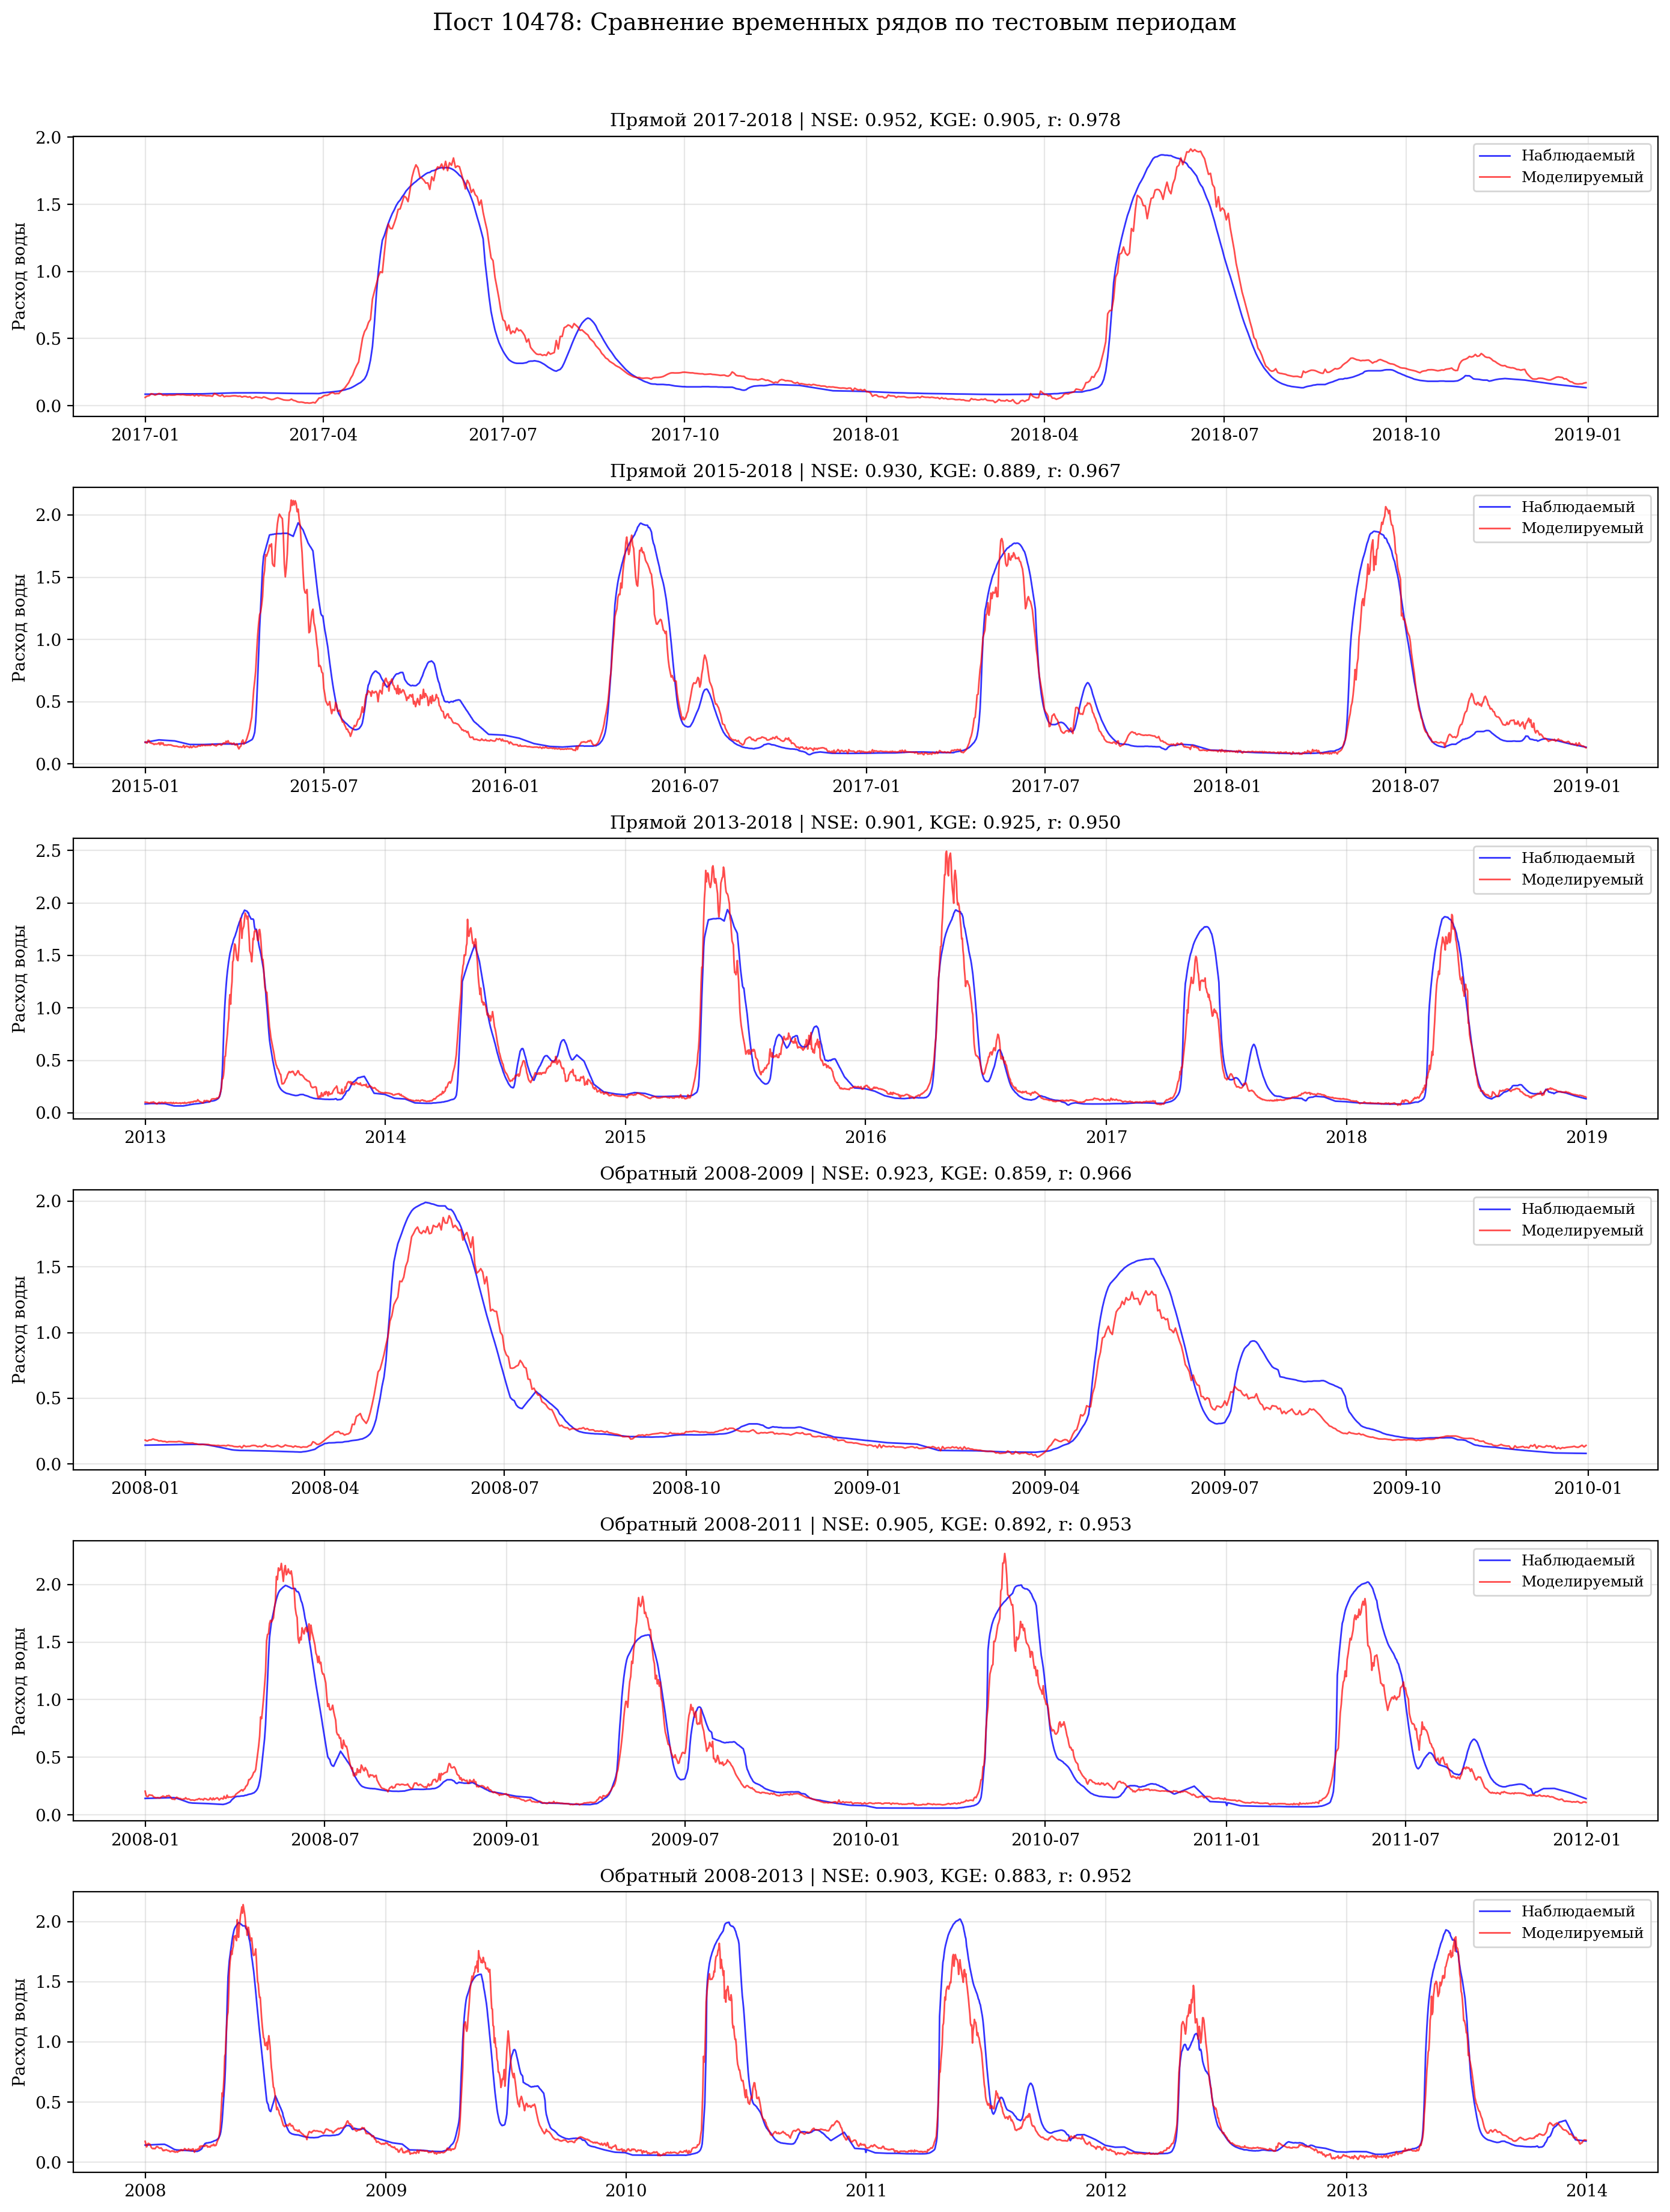

In [20]:
# Plot time series for best performing gauge
print(f"Best Performer: Gauge {best_gauge}")
plot_gauge_timeseries(best_gauge)

Median Performer: Gauge 84011


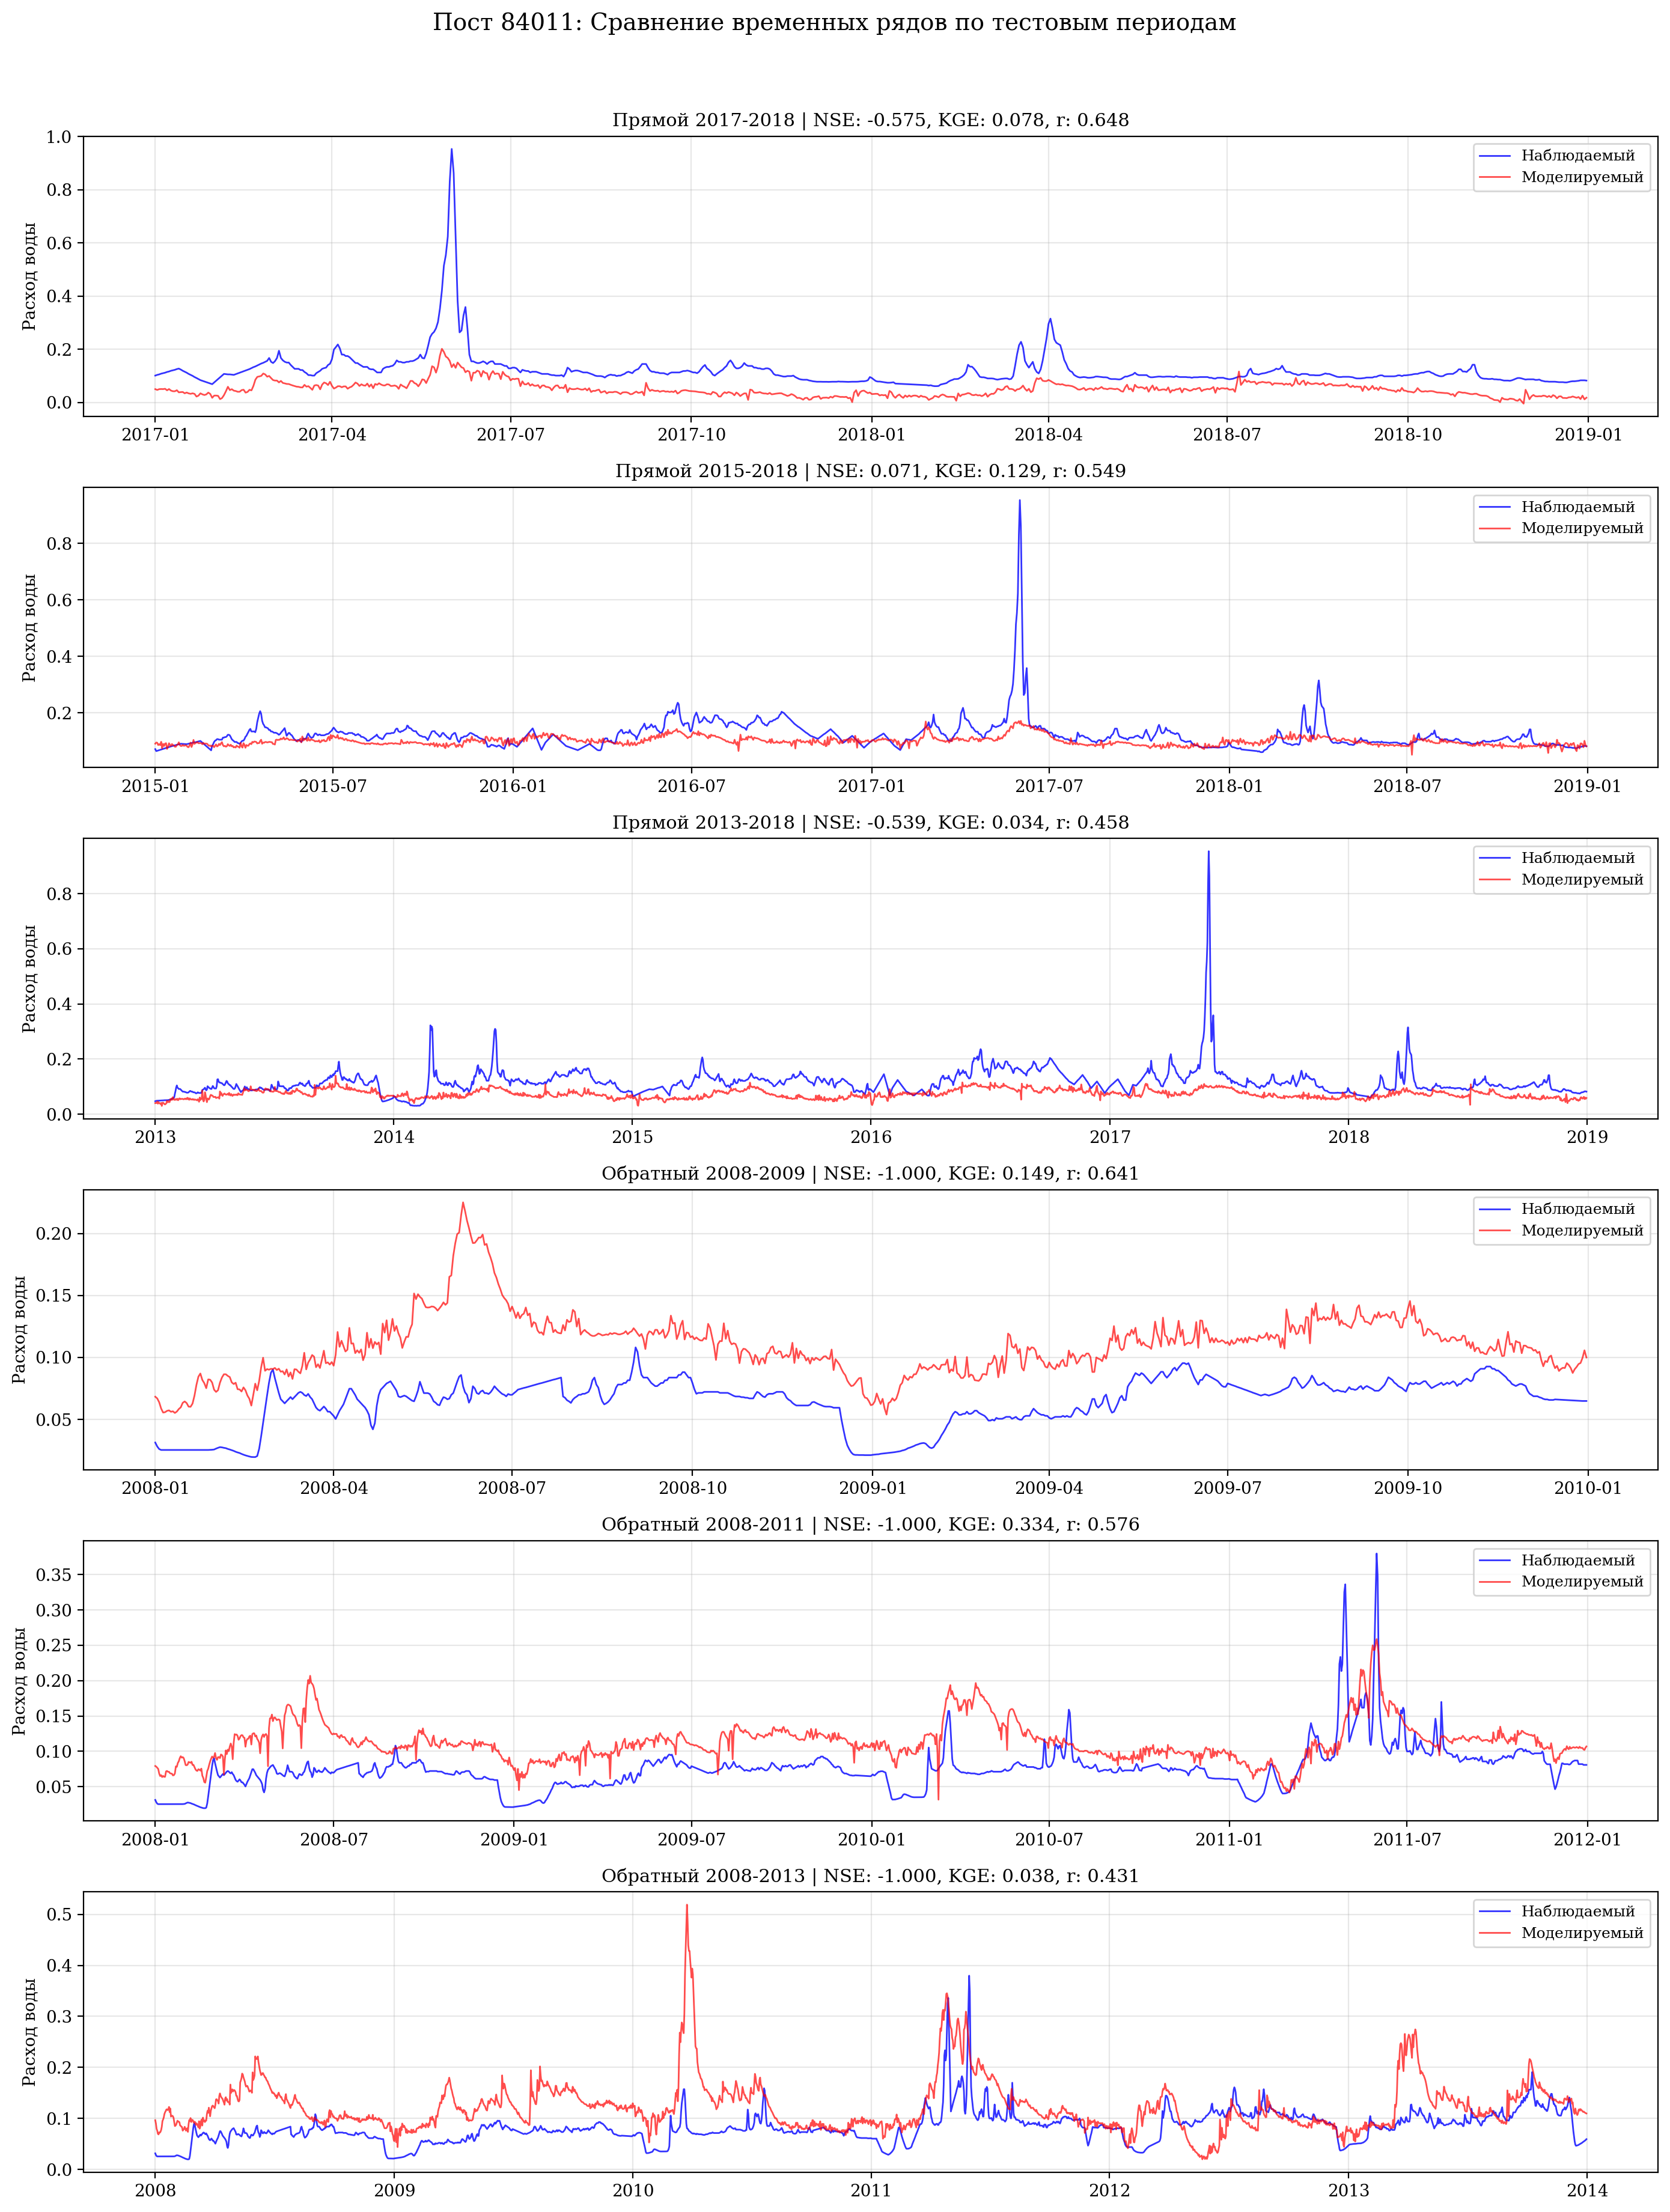

In [21]:
# Plot time series for median performing gauge
print(f"Median Performer: Gauge {median_gauge}")
plot_gauge_timeseries(median_gauge)

Worst Performer: Gauge 84011


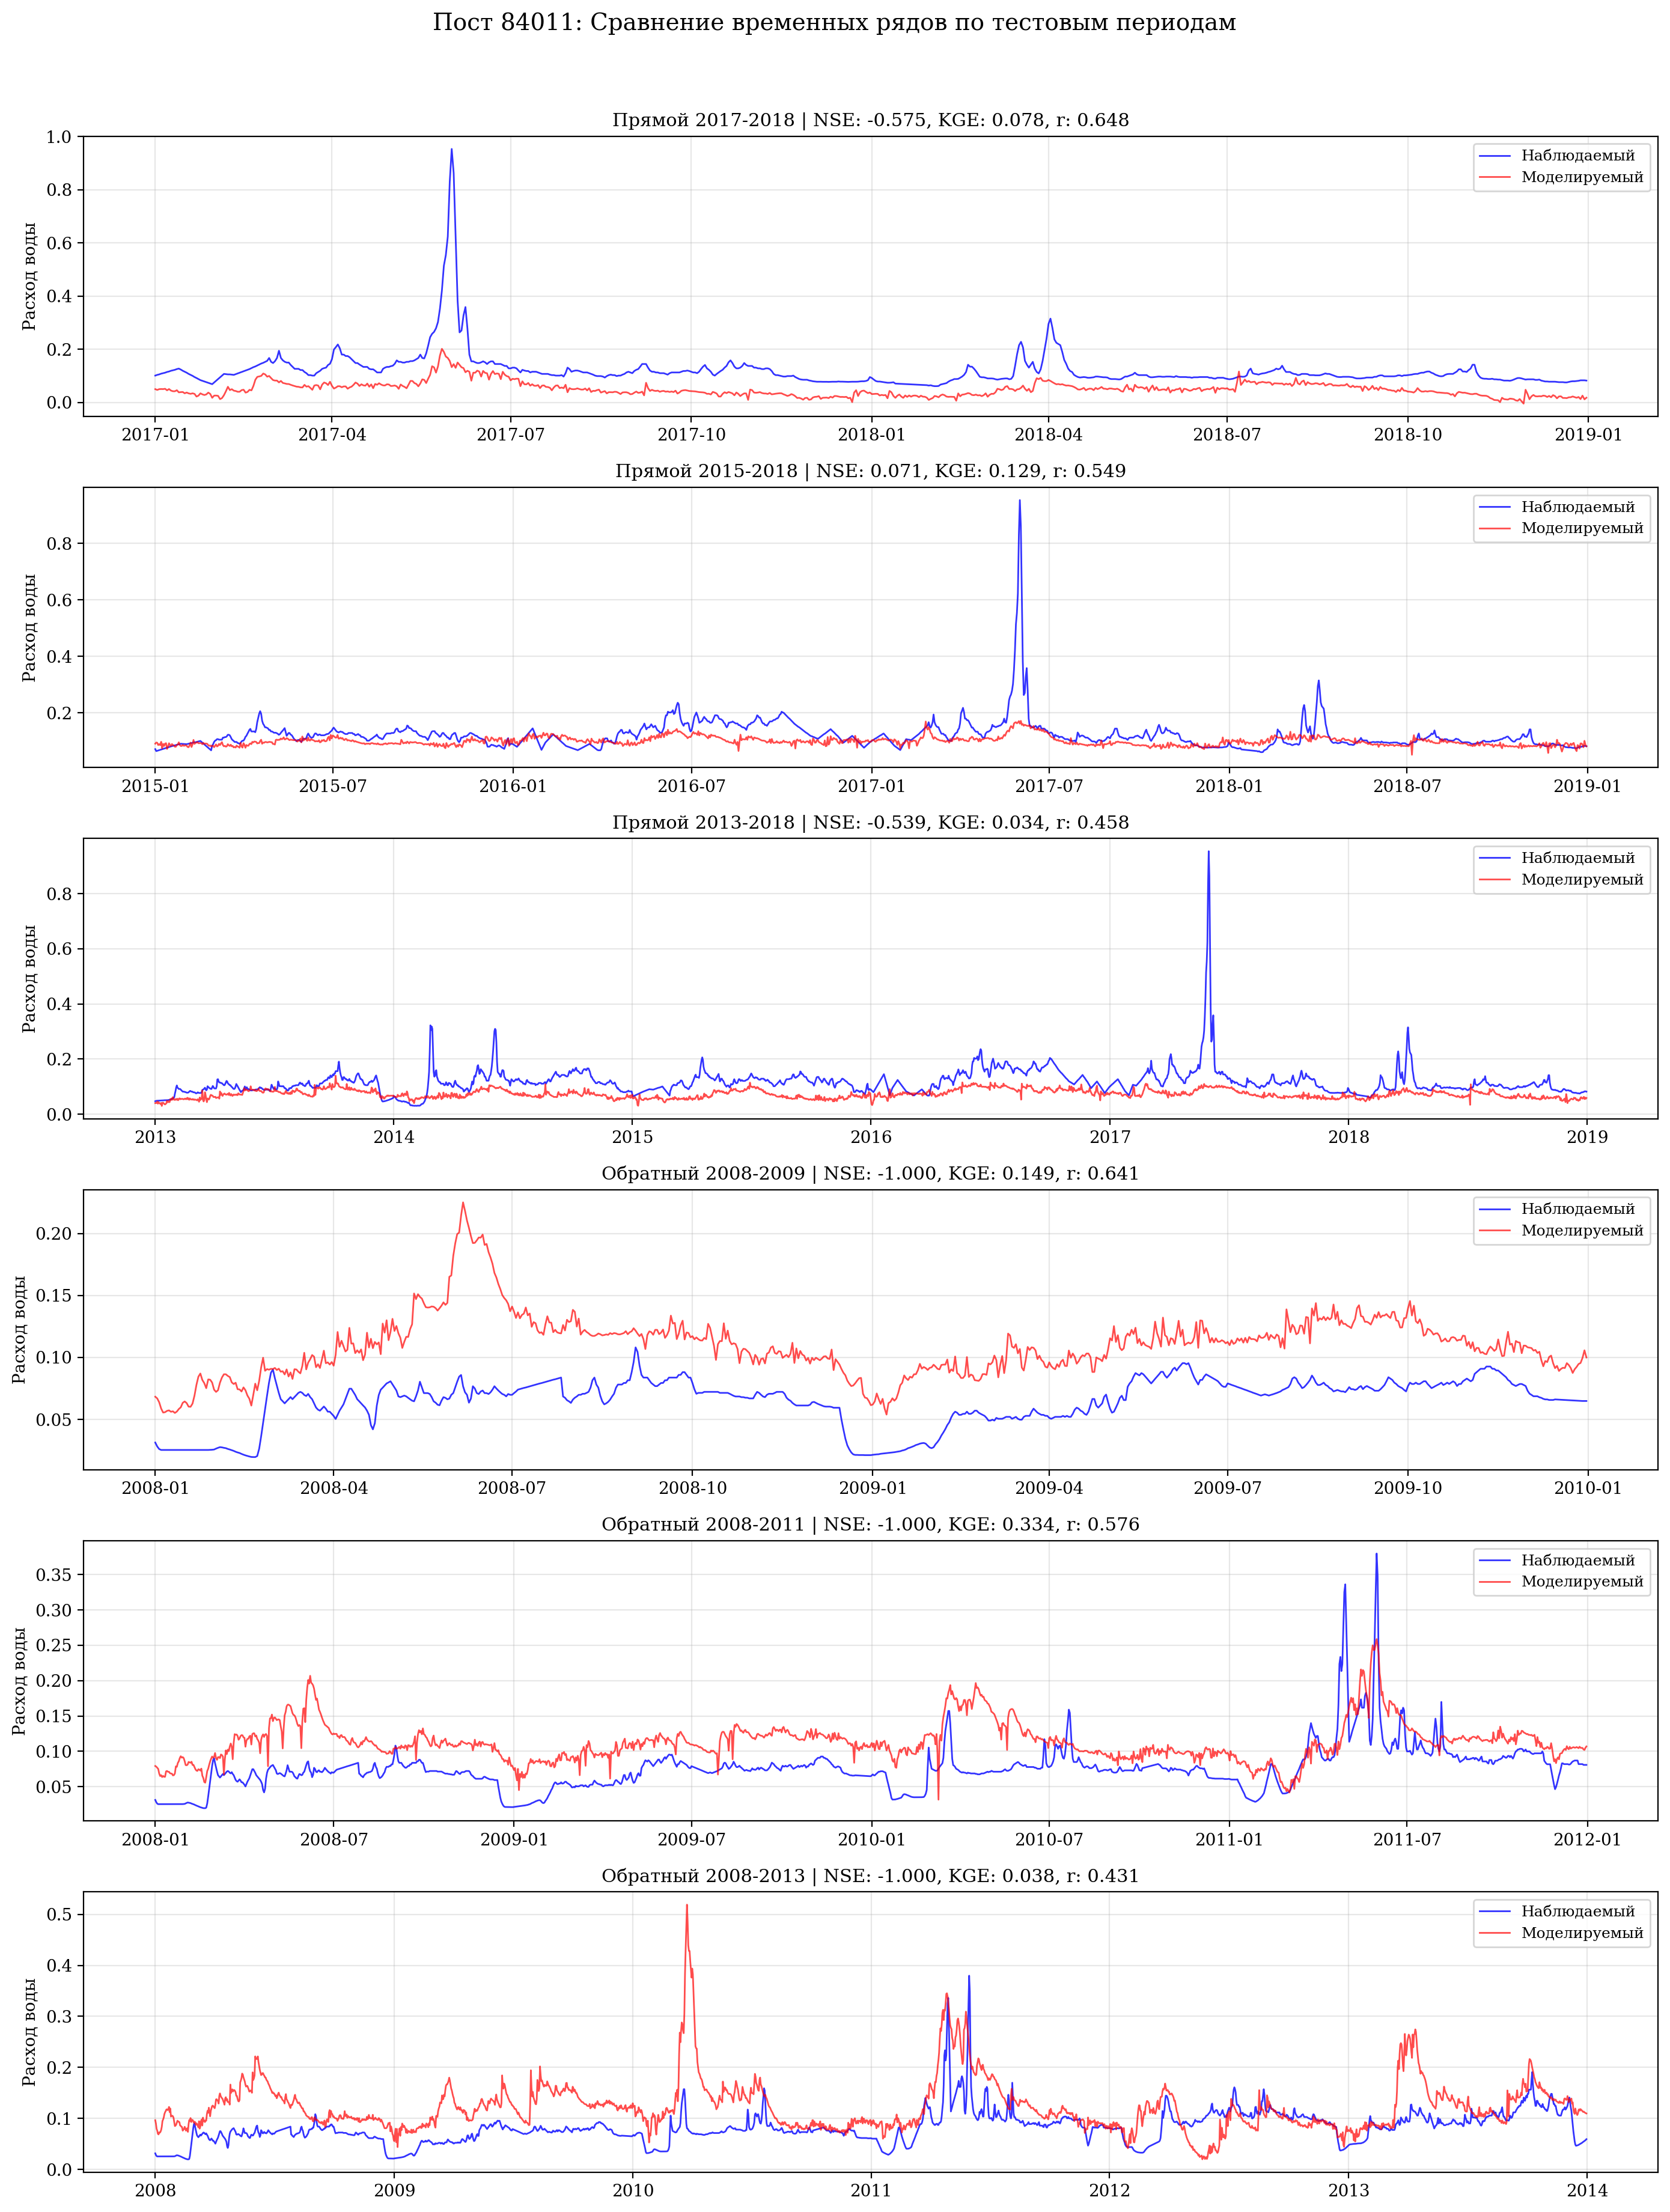

In [22]:
# Plot time series for worst performing gauge
print(f"Worst Performer: Gauge {worst_gauge}")
plot_gauge_timeseries(worst_gauge)


Comparing Forward vs Backward periods for Gauge 84011:


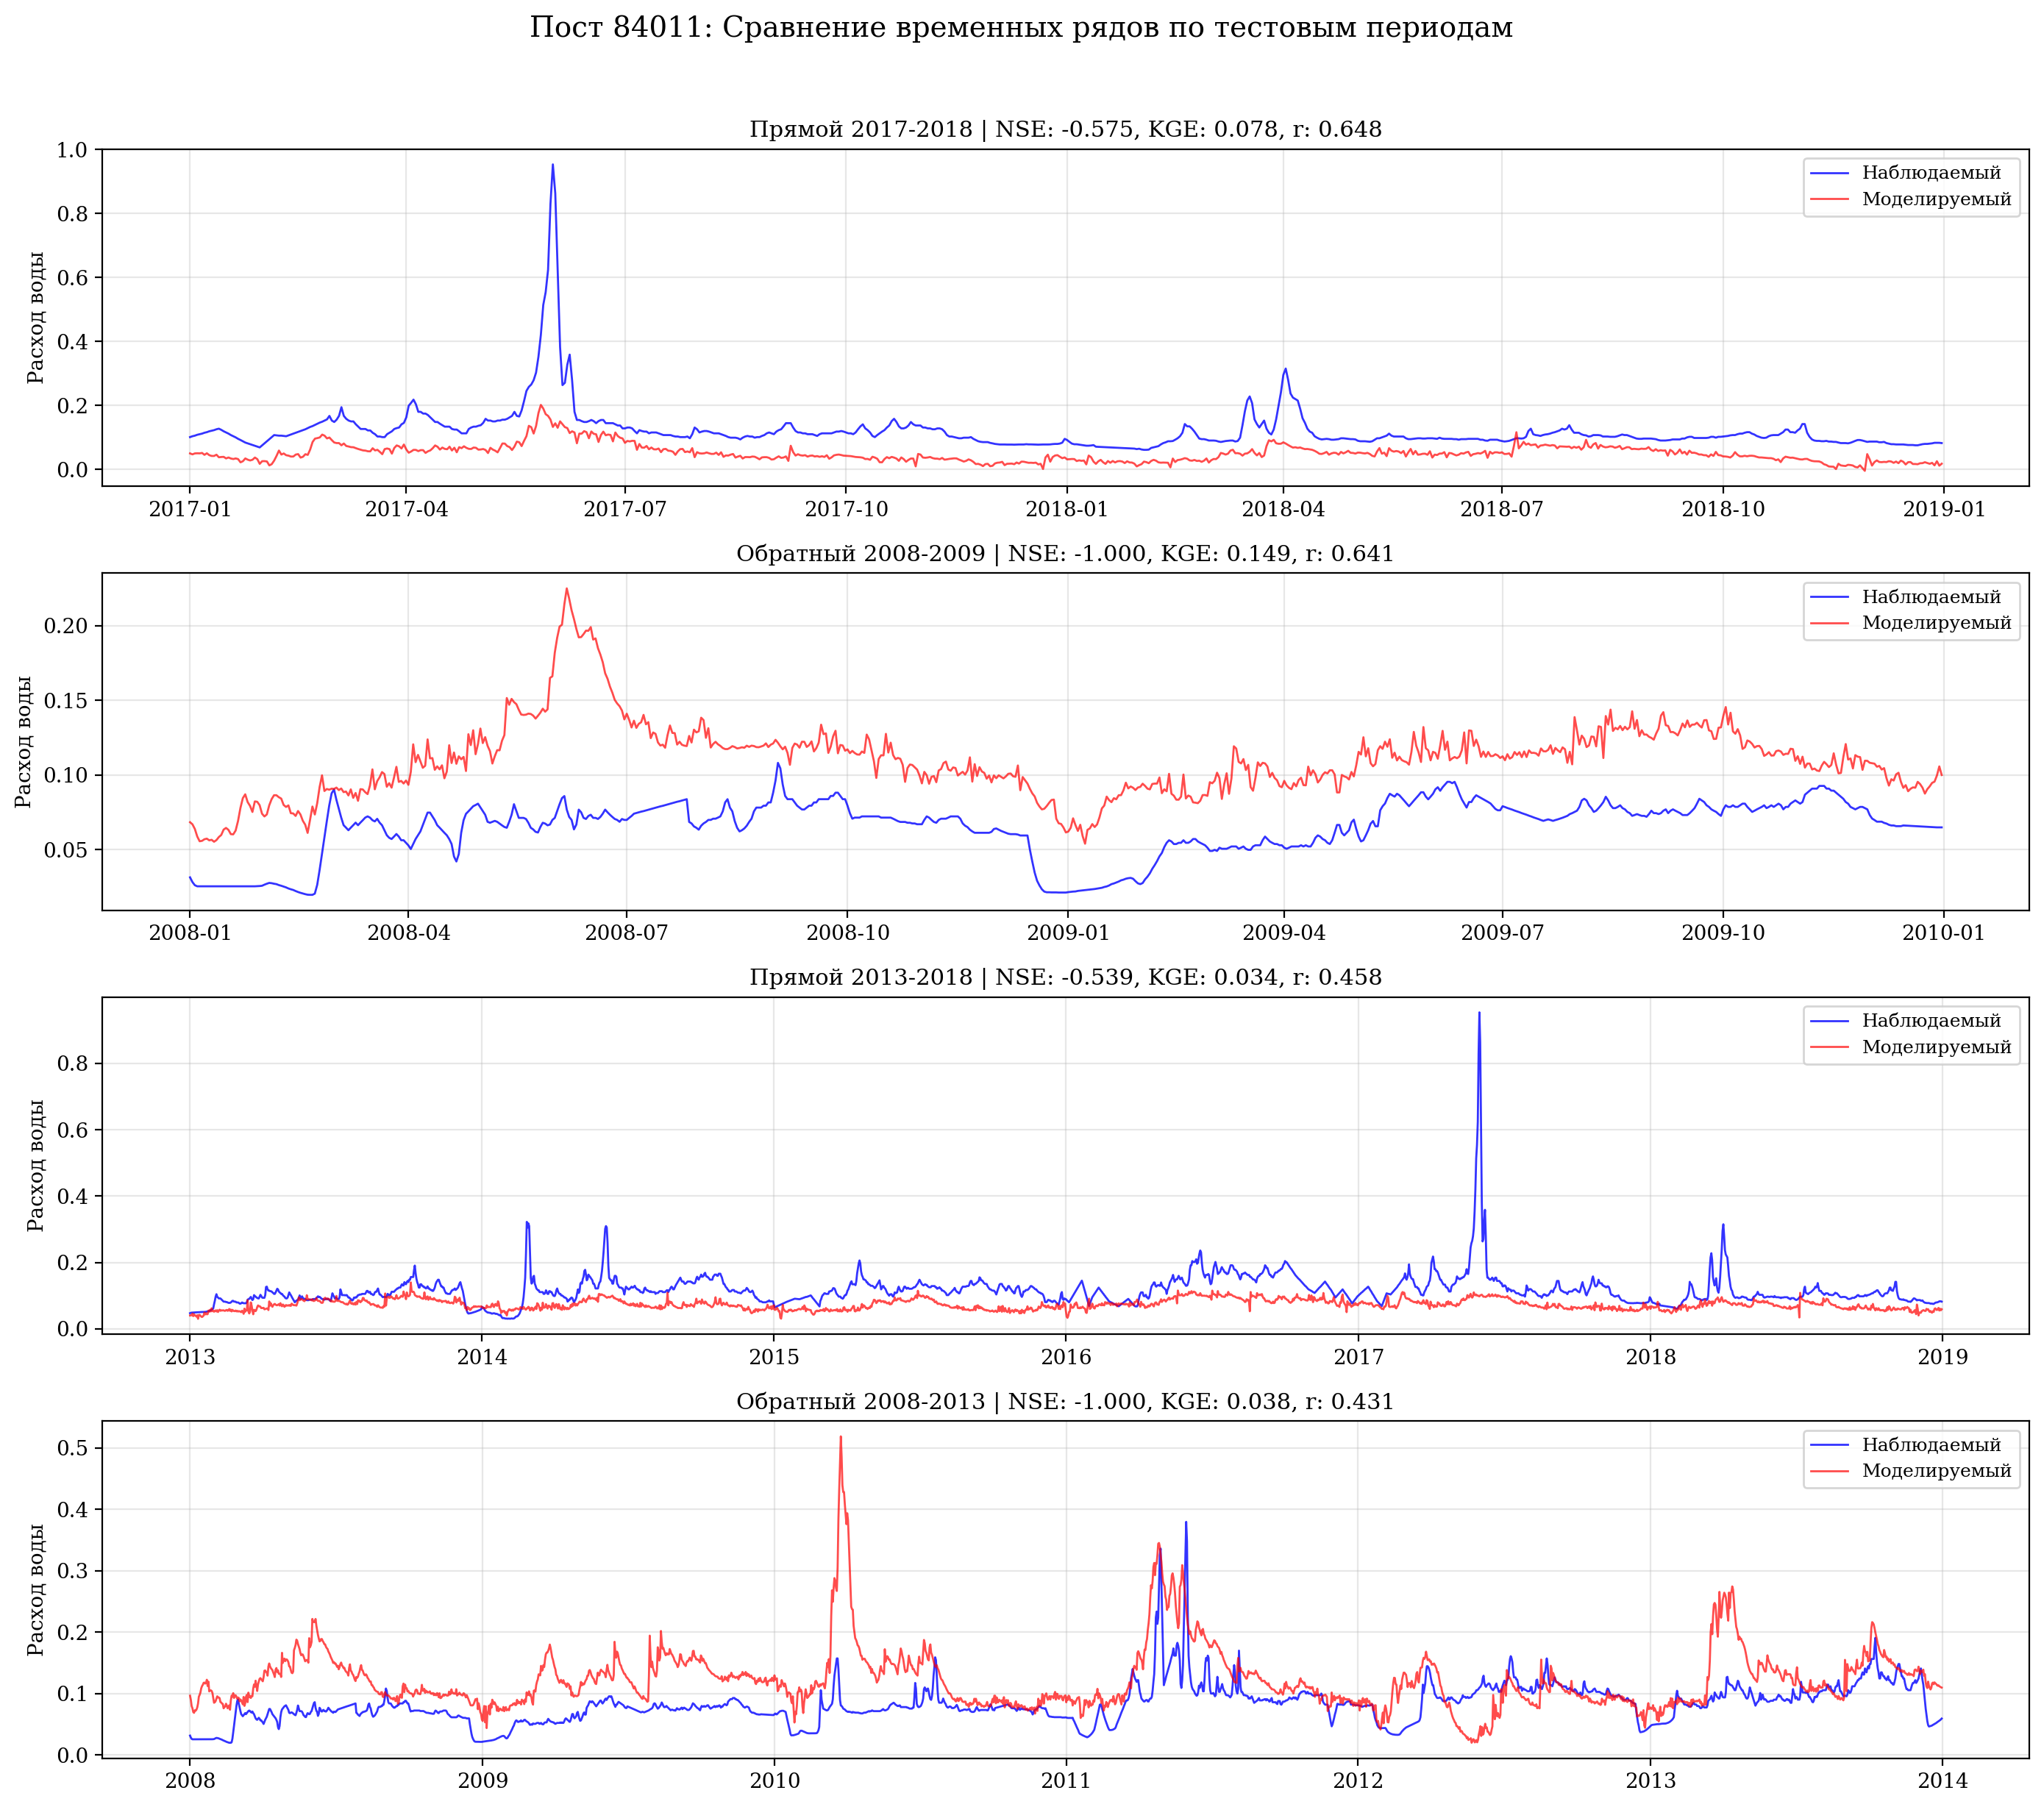

In [23]:
# Compare forward vs backward for median gauge (focused view)
print(f"\nComparing Forward vs Backward periods for Gauge {median_gauge}:")
plot_gauge_timeseries(
    median_gauge, periods_to_plot=["forward_1", "back_1", "forward_3", "back_3"]
)

## Summary

In [24]:
# Generate summary report for NSE, KGE, r
print("=" * 80)
print("LSTM TEST PERIOD EVALUATION SUMMARY")
print("Focus: NSE (clipped to [-1,1]), KGE, Pearson r")
print("=" * 80)

print(f"\nTotal gauges analyzed: {metrics_df.index.nunique()}")
print("\nExperiment Configuration (Train | Val | Test):")
print("-" * 80)
for period in test_periods:
    info = period_info[period]
    print(f"  {period} ({info['direction']}):")
    print(
        f"    Train: {info['train_years']} ({info['train_duration']} yrs) | "
        f"Val: {info['val_years']} ({info['val_duration']} yrs) | "
        f"Test: {info['test_years']} ({info['test_duration']} yrs)"
    )

print("\n" + "-" * 60)
print("Performance by Period (NSE, KGE, r):")
print("-" * 60)

for period in test_periods:
    test_years = period_info[period]["test_years"]
    direction = period_info[period]["direction"]

    period_nse_clip = metrics_wide["NSE_clipped"][period].dropna()
    period_nse = metrics_wide["NSE"][period].dropna()
    period_kge = metrics_wide["KGE"][period].dropna()
    period_r = metrics_wide["r"][period].dropna()

    print(f"\n{period} ({test_years}, {direction}):")
    print(
        f"  NSE - Median: {period_nse_clip.median():.3f}, Satisfactory (>=0.5): {(period_nse >= 0.5).mean() * 100:.1f}%"
    )
    print(
        f"  KGE - Median: {period_kge.median():.3f}, Satisfactory (>=0.5): {(period_kge >= 0.5).mean() * 100:.1f}%"
    )
    print(
        f"  r   - Median: {period_r.median():.3f}, Satisfactory (>=0.7): {(period_r >= 0.7).mean() * 100:.1f}%"
    )

print("\n" + "-" * 60)
print("Key Findings:")
print("-" * 60)

# Calculate overall forward vs backward comparison using clipped NSE
forward_nse = metrics_df[metrics_df["direction"] == "Forward"]["NSE_clipped"].median()
backward_nse = metrics_df[metrics_df["direction"] == "Backward"]["NSE_clipped"].median()
forward_kge = metrics_df[metrics_df["direction"] == "Forward"]["KGE"].median()
backward_kge = metrics_df[metrics_df["direction"] == "Backward"]["KGE"].median()
forward_r = metrics_df[metrics_df["direction"] == "Forward"]["r"].median()
backward_r = metrics_df[metrics_df["direction"] == "Backward"]["r"].median()

print("\n1. Forward vs Backward Direction (median values):")
print(
    f"   NSE: Forward={forward_nse:.3f}, Backward={backward_nse:.3f}, Diff={forward_nse - backward_nse:.3f}"
)
print(
    f"   KGE: Forward={forward_kge:.3f}, Backward={backward_kge:.3f}, Diff={forward_kge - backward_kge:.3f}"
)
print(
    f"   r:   Forward={forward_r:.3f}, Backward={backward_r:.3f}, Diff={forward_r - backward_r:.3f}"
)

# Period length effect
period_1_nse = metrics_df[metrics_df["period_length"] == 1]["NSE_clipped"].median()
period_3_nse = metrics_df[metrics_df["period_length"] == 3]["NSE_clipped"].median()
period_1_kge = metrics_df[metrics_df["period_length"] == 1]["KGE"].median()
period_3_kge = metrics_df[metrics_df["period_length"] == 3]["KGE"].median()
period_1_r = metrics_df[metrics_df["period_length"] == 1]["r"].median()
period_3_r = metrics_df[metrics_df["period_length"] == 3]["r"].median()

print("\n2. Period Length Effect (2yr vs 6yr test):")
print(
    f"   NSE: 2yr={period_1_nse:.3f}, 6yr={period_3_nse:.3f}, Change={period_3_nse - period_1_nse:.3f}"
)
print(
    f"   KGE: 2yr={period_1_kge:.3f}, 6yr={period_3_kge:.3f}, Change={period_3_kge - period_1_kge:.3f}"
)
print(
    f"   r:   2yr={period_1_r:.3f}, 6yr={period_3_r:.3f}, Change={period_3_r - period_1_r:.3f}"
)

print("\n" + "=" * 80)

LSTM TEST PERIOD EVALUATION SUMMARY
Focus: NSE (clipped to [-1,1]), KGE, Pearson r

Total gauges analyzed: 996

Experiment Configuration (Train | Val | Test):
--------------------------------------------------------------------------------
  forward_1 (Forward):
    Train: 2008-2014 (7 yrs) | Val: 2015-2016 (2 yrs) | Test: 2017-2018 (2 yrs)
  forward_2 (Forward):
    Train: 2008-2012 (5 yrs) | Val: 2013-2014 (2 yrs) | Test: 2015-2018 (4 yrs)
  forward_3 (Forward):
    Train: 2008-2010 (3 yrs) | Val: 2011-2012 (2 yrs) | Test: 2013-2018 (6 yrs)
  back_1 (Backward):
    Train: 2012-2018 (7 yrs) | Val: 2010-2011 (2 yrs) | Test: 2008-2009 (2 yrs)
  back_2 (Backward):
    Train: 2014-2018 (5 yrs) | Val: 2012-2013 (2 yrs) | Test: 2008-2011 (4 yrs)
  back_3 (Backward):
    Train: 2016-2018 (3 yrs) | Val: 2014-2015 (2 yrs) | Test: 2008-2013 (6 yrs)

------------------------------------------------------------
Performance by Period (NSE, KGE, r):
-------------------------------------------------